In [93]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, StratifiedKFold, RandomizedSearchCV
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import GradientBoostingRegressor
from scipy.stats import randint, uniform
from sklearn.metrics import mean_absolute_error, root_mean_squared_error, r2_score

pd.set_option('display.max_columns', None)

In [94]:
DATA_PATH = r'data_final_ready.csv'

In [95]:
df = pd.read_csv(DATA_PATH)

In [96]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16454 entries, 0 to 16453
Data columns (total 62 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   age                             16452 non-null  float64
 1   height                          16453 non-null  float64
 2   nationality                     16216 non-null  object 
 3   position                        16451 non-null  object 
 4   position_category               16454 non-null  object 
 5   current_club                    16454 non-null  object 
 6   league                          16454 non-null  object 
 7   appearances                     16454 non-null  int64  
 8   minutes_played                  16454 non-null  int64  
 9   is_GK                           16454 non-null  int64  
 10  is_DF                           16454 non-null  int64  
 11  is_MF                           16454 non-null  int64  
 12  is_FW                           

In [97]:
print(df['position_category'].value_counts())

position_category
MF         6706
DF         5897
FW         2371
GK         1477
UNKNOWN       3
Name: count, dtype: int64


In [98]:
df.groupby('position_category')['market_value'].describe()

count      mean        std   min    25%  50%   75%    max
position_category                                                            
DF                 5897.0  3.174476   8.538011  0.01  0.250  0.6  2.00  140.0
FW                 2371.0  2.705038   8.423822  0.01  0.200  0.5  1.50  140.0
GK                 1477.0  2.034408   5.849736  0.01  0.125  0.3  1.00   80.0
MF                 6706.0  3.965687  11.457767  0.01  0.300  0.7  2.50  200.0
UNKNOWN               3.0  0.983333   0.977667  0.05  0.475  0.9  1.45    2.0

# FW model

In [99]:
df_fw = df[df['is_FW'] == 1]

In [100]:
df_fw.info()

<class 'pandas.core.frame.DataFrame'>
Index: 2371 entries, 1 to 16445
Data columns (total 62 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   age                             2371 non-null   float64
 1   height                          2371 non-null   float64
 2   nationality                     2318 non-null   object 
 3   position                        2371 non-null   object 
 4   position_category               2371 non-null   object 
 5   current_club                    2371 non-null   object 
 6   league                          2371 non-null   object 
 7   appearances                     2371 non-null   int64  
 8   minutes_played                  2371 non-null   int64  
 9   is_GK                           2371 non-null   int64  
 10  is_DF                           2371 non-null   int64  
 11  is_MF                           2371 non-null   int64  
 12  is_FW                           2371 n

In [101]:
# df['goals_x_assists'] = df['goals'] * df['assists']
# df['age_height'] = df['age'] * df['height']
# df['xg_per_shot'] = df['xg_per90'] / (df['shots_per90'] + 1e-6)
# df['goals_per_shot'] = df['goals'] / (df['shots_per90'] + 1e-6)
# df['assists_per_takeon'] = df['assists'] / (df['take_ons_per90'] + 1e-6)

In [102]:
info_columns = ['height', 'position', 'nationality', 'current_club', 'league', 
                'appearances', 'minutes_played','age_group', 'experience_level']
TARGET = 'market_value'

In [103]:
fw_cols = [
    'goals_per_90', 'npg_per90', 'npxg_per90',
    'xag_per90',

    'shots_per90', 'shots_on_target_per90',
    'shots_on_target_pct', 'avg_shot_distance',
    'shooting_efficiency',
    
    'assists_per_90',

    'sca_per90', 'gca_per90', 'key_passes_per90',

    'passes_completed_per90','passes_into_final_third_per90',
    'passes_into_penalty_area_per90', 'progressive_passes_per90',
    'is_high_passer',

    'progressive_carries_per90', 'take_ons_per90',
    'take_on_success_pct', 'touches_att_third_per90',
    'touches_att_pen_per90'

    ]

fw_cols = info_columns + fw_cols  + [TARGET]

In [104]:
df_fw_selected = df_fw[fw_cols]

In [105]:
df_fw_selected.describe().T

count        mean         std     min  \
height                          2371.0  182.300295    6.074926  160.00   
appearances                     2371.0   15.460565   10.691829    0.00   
minutes_played                  2371.0  795.388865  761.861202    0.00   
goals_per_90                    2371.0    0.383159    0.380348    0.00   
npg_per90                       2371.0    0.258777    0.154007    0.00   
npxg_per90                      2371.0    0.290346    0.112425    0.00   
xag_per90                       2371.0    0.090430    0.052649    0.00   
shots_per90                     2371.0    2.269610    0.607033    0.00   
shots_on_target_per90           2371.0    0.819958    0.309358    0.00   
shots_on_target_pct             2371.0   36.427035    9.802507    0.00   
avg_shot_distance               2371.0   14.891523    2.360716    4.00   
shooting_efficiency             2371.0    0.216370    1.335419    0.00   
assists_per_90                  2371.0    0.173290    0.984544    0.00   
sca_per90                       2371.0    2.126099    0.627223    0.00   
gca_per90                       2371.0    0.232307    0.143696    0.00   
key_passes_per90                2371.0    0.910053    0.331205    0.00   
passes_completed_per90          2371.0   13.935938    3.855598    4.11   
passes_into_final_third_per90   2371.0    0.998380    0.450719    0.00   
passes_into_penalty_area_per90  2371.0    0.470173    0.296433    0.00   
progressive_passes_per90        2371.0    1.629275    0.655195    0.00   
is_high_passer                  2371.0    0.013075    0.113618    0.00   
progressive_carries_per90       2371.0    1.213011    0.728765    0.00   
take_ons_per90                  2371.0    0.744197    0.474358    0.00   
take_on_success_pct             2371.0   40.070519   12.689646    0.00   
touches_att_third_per90         2371.0   15.119873    3.068078    1.85   
touches_att_pen_per90           2371.0    4.069488    0.947982    0.00   
market_value                    2371.0    2.705038    8.423822    0.01   

                                      25%         50%          75%      max  
height                          179.00000  183.000000   186.000000   202.00  
appearances                       6.00000   14.000000    24.000000    48.00  
minutes_played                  142.00000  565.000000  1250.500000  4026.00  
goals_per_90                      0.25000    0.340000     0.430000    12.86  
npg_per90                         0.25000    0.250000     0.250000     1.89  
npxg_per90                        0.28000    0.280000     0.290000     1.27  
xag_per90                         0.08000    0.080000     0.090000     0.62  
shots_per90                       2.24500    2.255000     2.270000     7.10  
shots_on_target_per90             0.80000    0.800000     0.800000     4.11  
shots_on_target_pct              36.40000   36.400000    36.400000   100.00  
avg_shot_distance                14.70000   14.700000    14.700000    40.30  
shooting_efficiency               0.11249    0.150776     0.191291    59.00  
assists_per_90                    0.09000    0.120000     0.160000    45.00  
sca_per90                         2.07000    2.070000     2.080000     7.42  
gca_per90                         0.22000    0.220000     0.220000     1.53  
key_passes_per90                  0.88000    0.885000     0.890000     3.40  
passes_completed_per90           13.36000   13.390000    13.425000    52.27  
passes_into_final_third_per90     0.95000    0.950000     0.950000     5.16  
passes_into_penalty_area_per90    0.42500    0.430000     0.430000     4.11  
progressive_passes_per90          1.53000    1.540000     1.545000     6.33  
is_high_passer                    0.00000    0.000000     0.000000     1.00  
progressive_carries_per90         1.08000    1.080000     1.090000     6.66  
take_ons_per90                    0.66500    0.670000     0.670000     5.27  
take_on_success_pct              40.00000   40.000000    40.000000   100.00  
touches_at

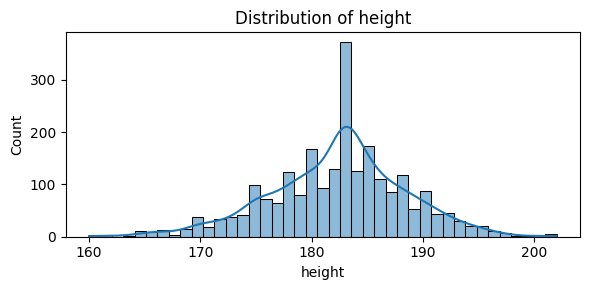

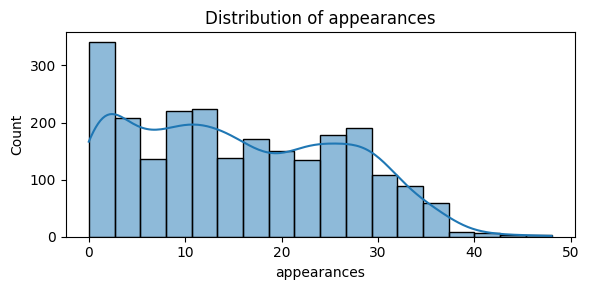

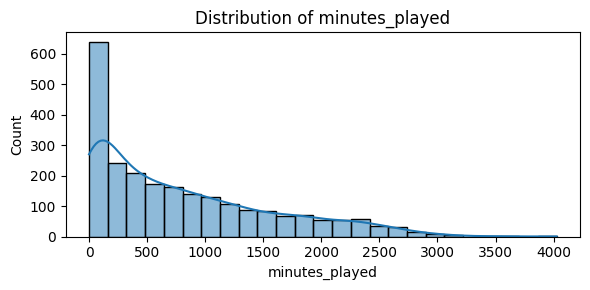

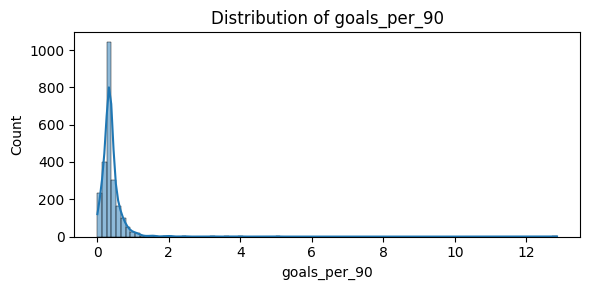

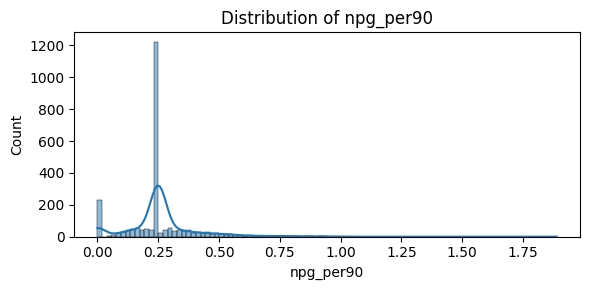

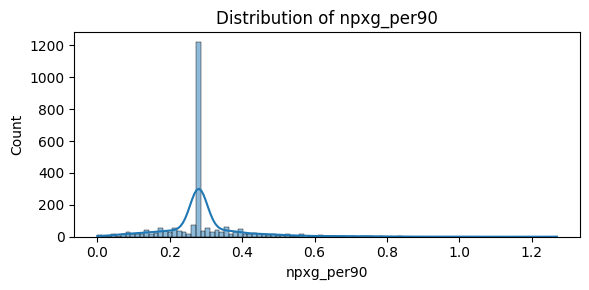

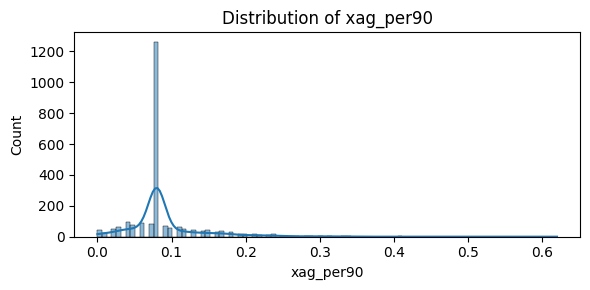

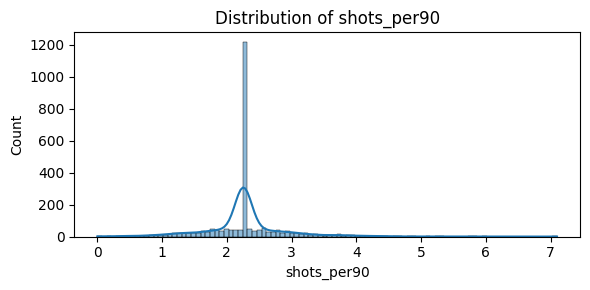

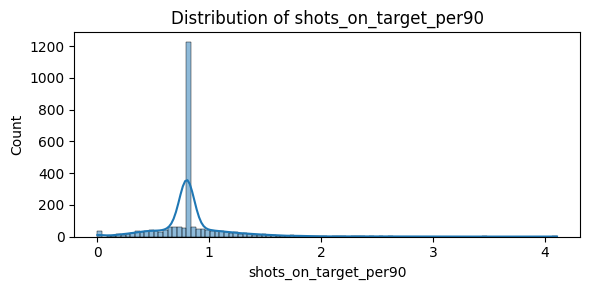

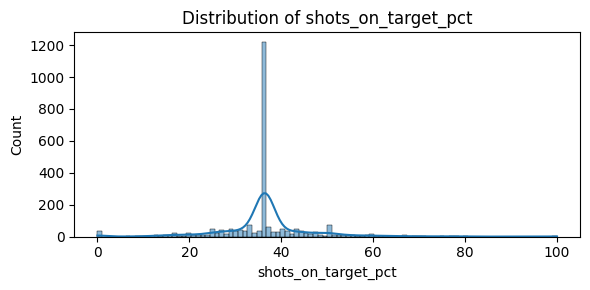

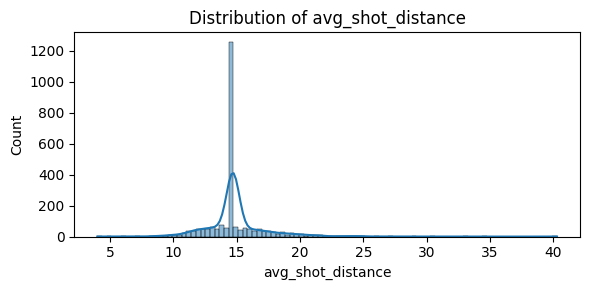

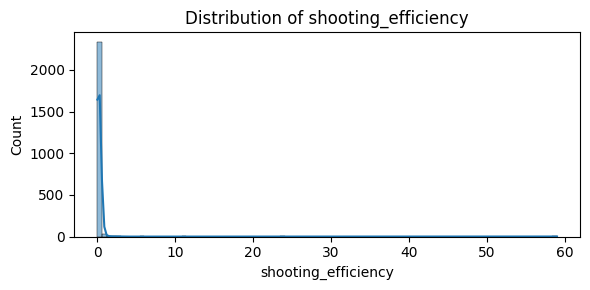

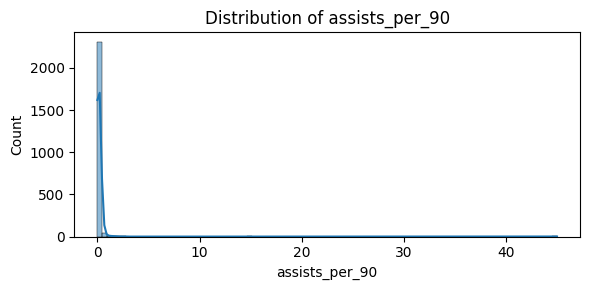

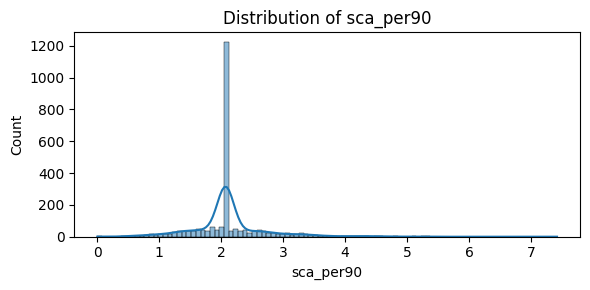

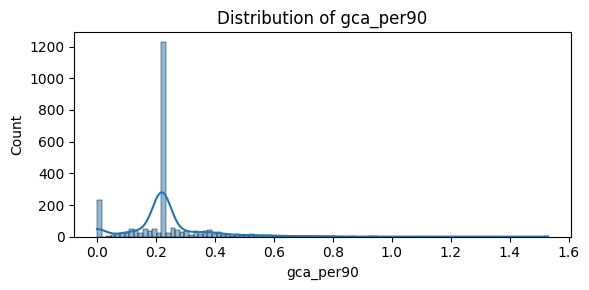

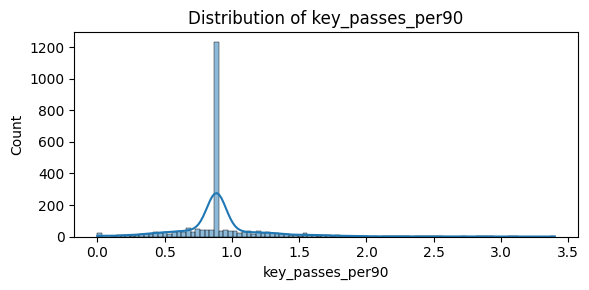

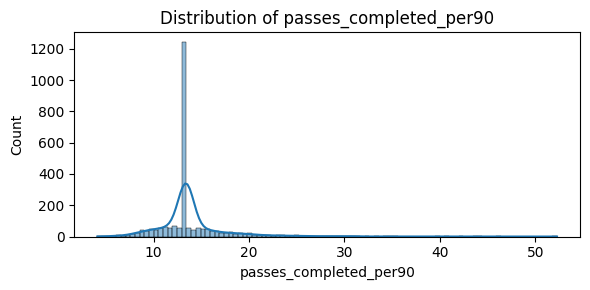

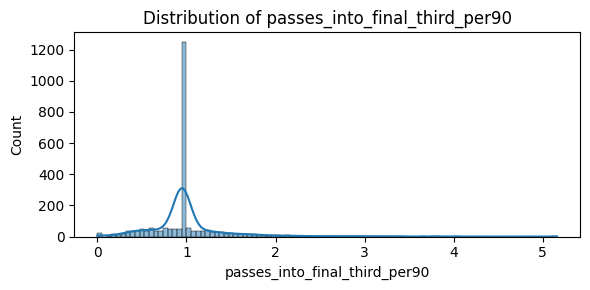

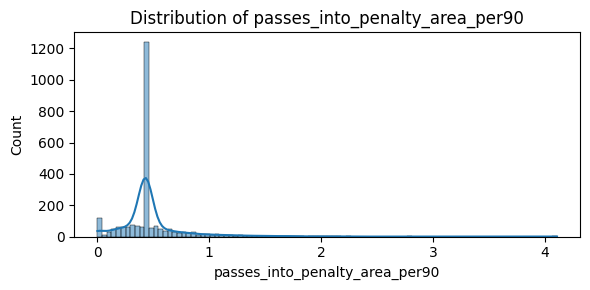

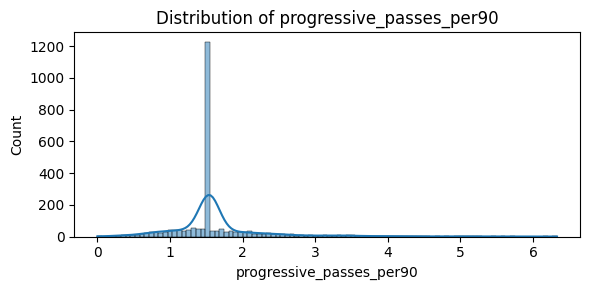

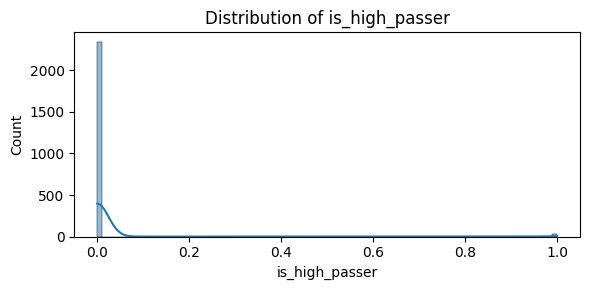

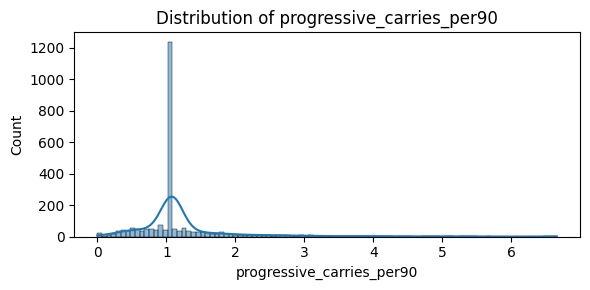

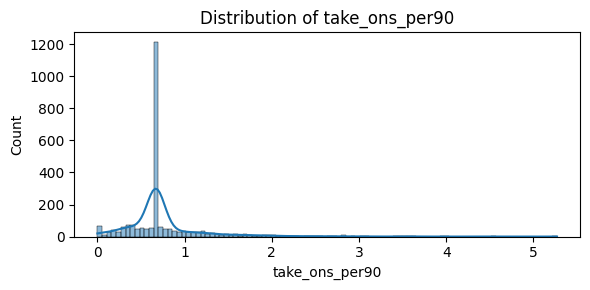

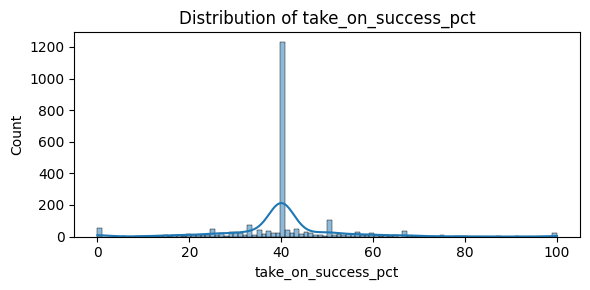

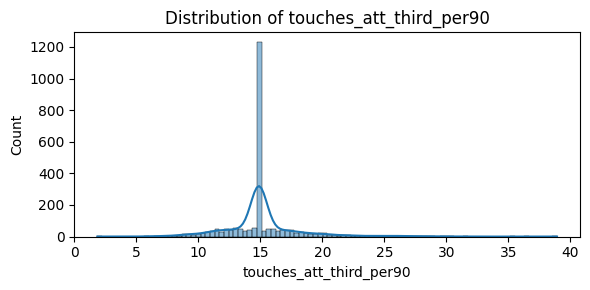

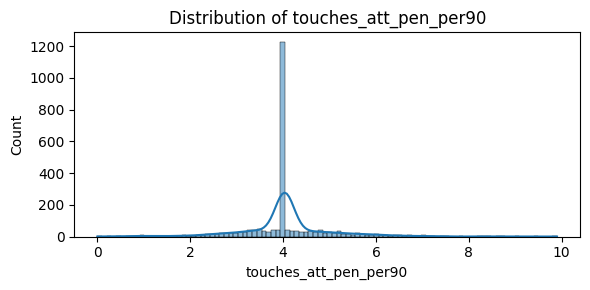

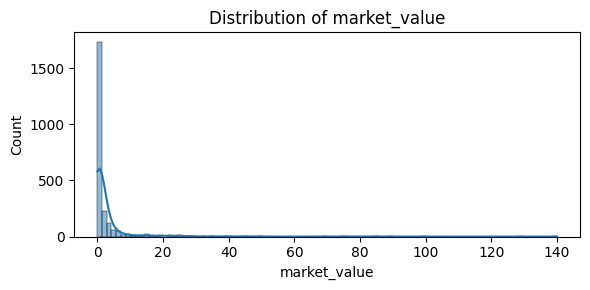

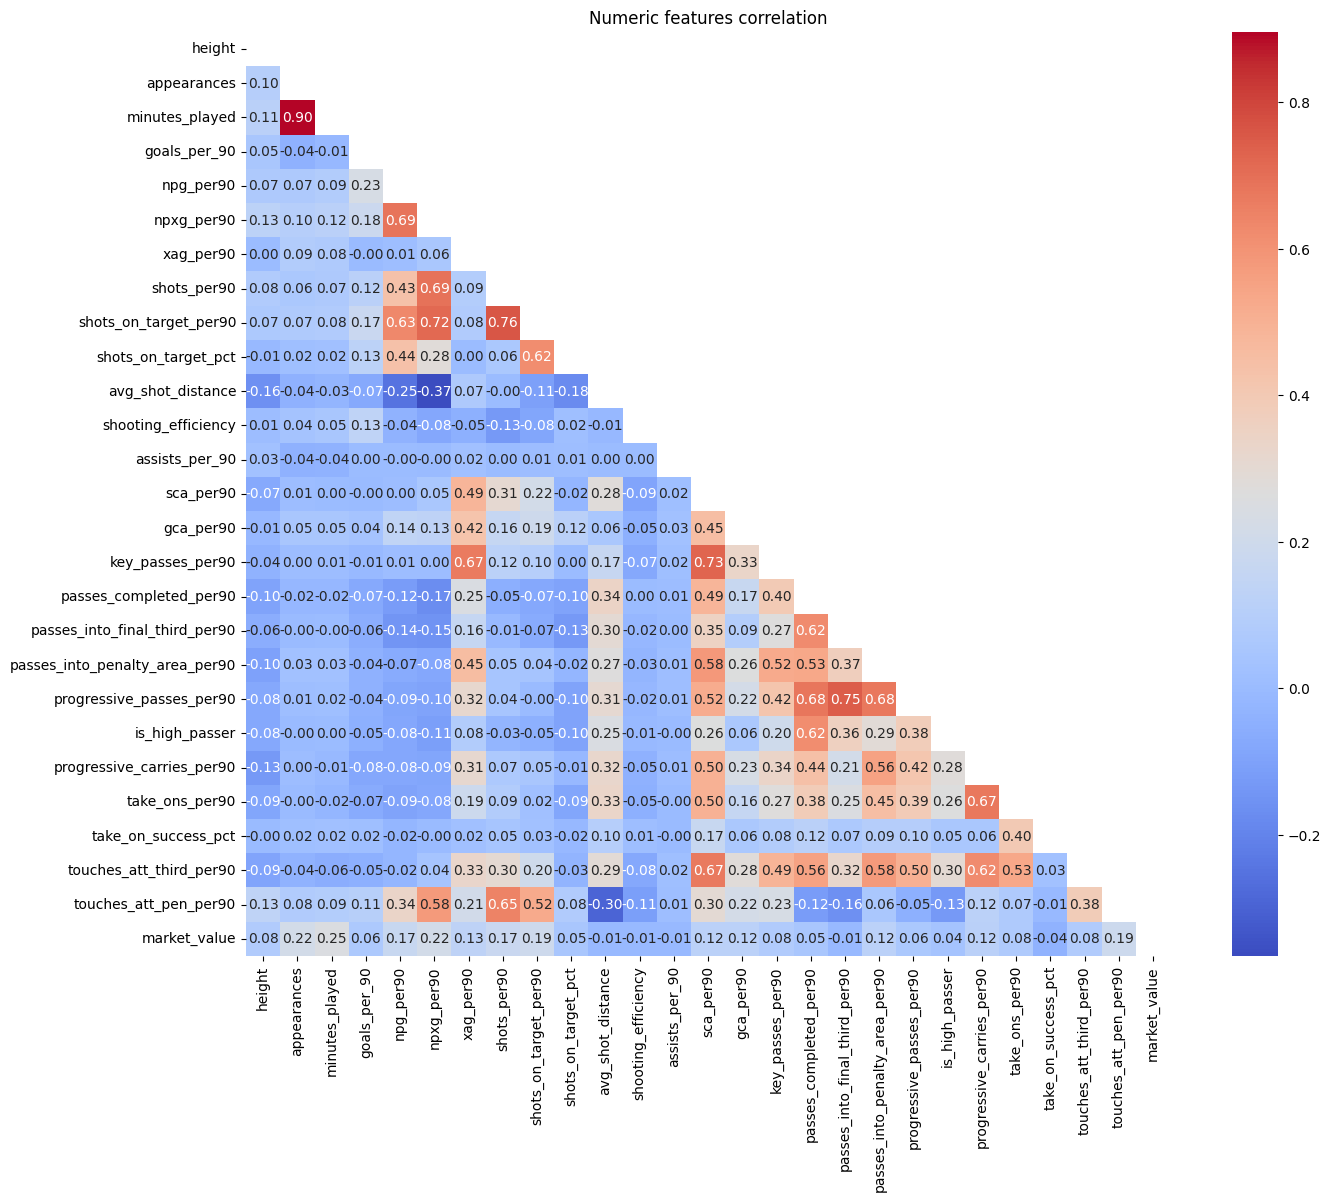

In [106]:
num_cols = df_fw_selected.select_dtypes(include=[np.number]).columns.tolist()


for c in num_cols:
    plt.figure(figsize=(6,3))
    sns.histplot(df_fw_selected[c].dropna(), kde=True)
    plt.title(f'Distribution of {c}')
    plt.tight_layout()
    plt.show()

corr = df_fw_selected[num_cols].corr()

# Tạo mask tam giác trên
mask = np.triu(np.ones_like(corr, dtype=bool))

plt.figure(figsize=(16, 12))
sns.heatmap(
    corr,
    mask=mask,
    annot=True,
    fmt='.2f',
    cmap='coolwarm',
    square=True
)
plt.title('Numeric features correlation')
plt.show()

In [107]:
X_fw = df_fw_selected.drop(columns=[TARGET])
y_fw = df_fw_selected[TARGET]

In [108]:
bins = pd.qcut(np.log1p(y_fw), q=10, labels=False, duplicates='drop')
X_fw_train, X_fw_test, y_fw_train, y_fw_test = train_test_split(X_fw, y_fw, test_size = 0.2, random_state=42, stratify=bins)

<Axes: >

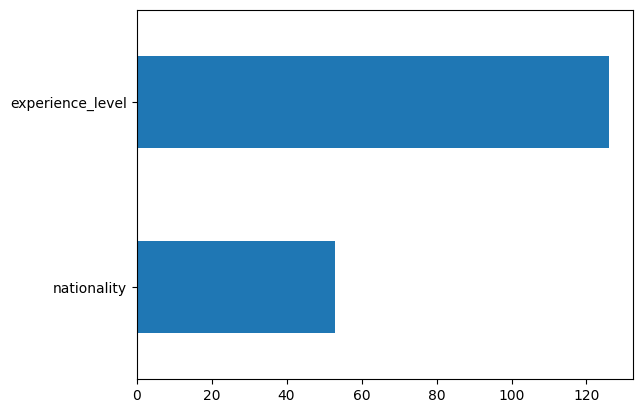

In [109]:
fw_missing = df_fw_selected.isna().sum()
fw_missing= fw_missing[fw_missing > 0].sort_values()

fw_missing.plot(kind='barh')

In [110]:
num_cols = X_fw_train.select_dtypes(include=[np.number]).columns.tolist()

In [111]:
cat_cols = X_fw_train.select_dtypes(exclude=[np.number]).columns.tolist()

In [112]:
nationality_missing_fill = X_fw_train['nationality'].mode()[0]
X_fw_train['nationality'] = X_fw_train['nationality'].fillna(nationality_missing_fill)
X_fw_test['nationality'] = X_fw_test['nationality'].fillna(nationality_missing_fill)

In [113]:
X_fw_train['experience_level'] = X_fw_train['experience_level'].fillna(0)
X_fw_test['experience_level'] = X_fw_test['experience_level'].fillna(0)

In [114]:
X_fw_train = pd.get_dummies(X_fw_train, columns=cat_cols, drop_first=True)
X_fw_test = pd.get_dummies(X_fw_test, columns=cat_cols, drop_first=True)
X_fw_test = X_fw_test.reindex(columns=X_fw_train.columns, fill_value=0)

In [115]:
gb_model = GradientBoostingRegressor(random_state=42)

In [116]:
y_fw_train_log = np.log1p(y_fw_train)
y_fw_test_log = np.log1p(y_fw_test)

In [117]:
gb_model.fit(X_fw_train, y_fw_train_log)

GradientBoostingRegressor(random_state=42)

In [118]:
y_fw_pred_log = gb_model.predict(X_fw_test)
y_fw_pred = np.expm1(y_fw_pred_log)
mae = mean_absolute_error(y_fw_test, y_fw_pred)
rmse = root_mean_squared_error(y_fw_test, y_fw_pred)
r2 = r2_score(y_fw_test, y_fw_pred)

print(f'MAE: {mae:.4f}')
print(f'RMSE: {rmse:.4f}')
print(f'r2_score: {r2:.4f}')

MAE: 2.2732
RMSE: 8.9017
r2_score: 0.3471


In [119]:
param_dist = {
    'n_estimators': randint(200, 600),
    'learning_rate': uniform(0.03, 0.1),
    'max_depth': randint(2, 4),
    'min_samples_leaf': randint(10, 40),
    'subsample': uniform(0.7, 0.3),
    'max_features': ['sqrt', None],
    'loss': ['squared_error', 'huber']
}

In [120]:
fw_random_search = RandomizedSearchCV(
    GradientBoostingRegressor(
        random_state=42
    ),
    param_distributions=param_dist,
    n_iter=50,       
    cv=3,            
    scoring='neg_mean_absolute_error',
    n_jobs=-1,
    verbose=2,
    random_state=42
)


In [121]:
fw_random_search.fit(X_fw_train, y_fw_train_log)

Fitting 3 folds for each of 50 candidates, totalling 150 fits


RandomizedSearchCV(cv=3, estimator=GradientBoostingRegressor(random_state=42),
                   n_iter=50, n_jobs=-1,
                   param_distributions={'learning_rate': <scipy.stats._distn_infrastructure.rv_continuous_frozen object at 0x00000269893CB690>,
                                        'loss': ['squared_error', 'huber'],
                                        'max_depth': <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x00000269801E9F90>,
                                        'max_fe...
                                        'min_samples_leaf': <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x00000269801E9130>,
                                        'n_estimators': <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x0000026988475700>,
                                        'subsample': <scipy.stats._distn_infrastructure.rv_continuous_frozen object at 0x00000269893C84B0>},
                   random_state=42, scoring='neg_mean_absolute_error',
                   verbose=2)

In [122]:
best_model = fw_random_search.best_estimator_

In [123]:
y_fw_test_pred_log = best_model.predict(X_fw_test)
y_fw_test_pred = np.expm1(y_fw_test_pred_log)

In [124]:
mae = mean_absolute_error(y_fw_test, y_fw_test_pred)
rmse = root_mean_squared_error(y_fw_test, y_fw_test_pred)
r2 = r2_score(y_fw_test, y_fw_test_pred)

print(f'MAE: {mae:.4f}')
print(f'RMSE: {rmse:.4f}')
print(f'r2_score: {r2:.4f}')

MAE: 2.0521
RMSE: 8.2583
r2_score: 0.4381


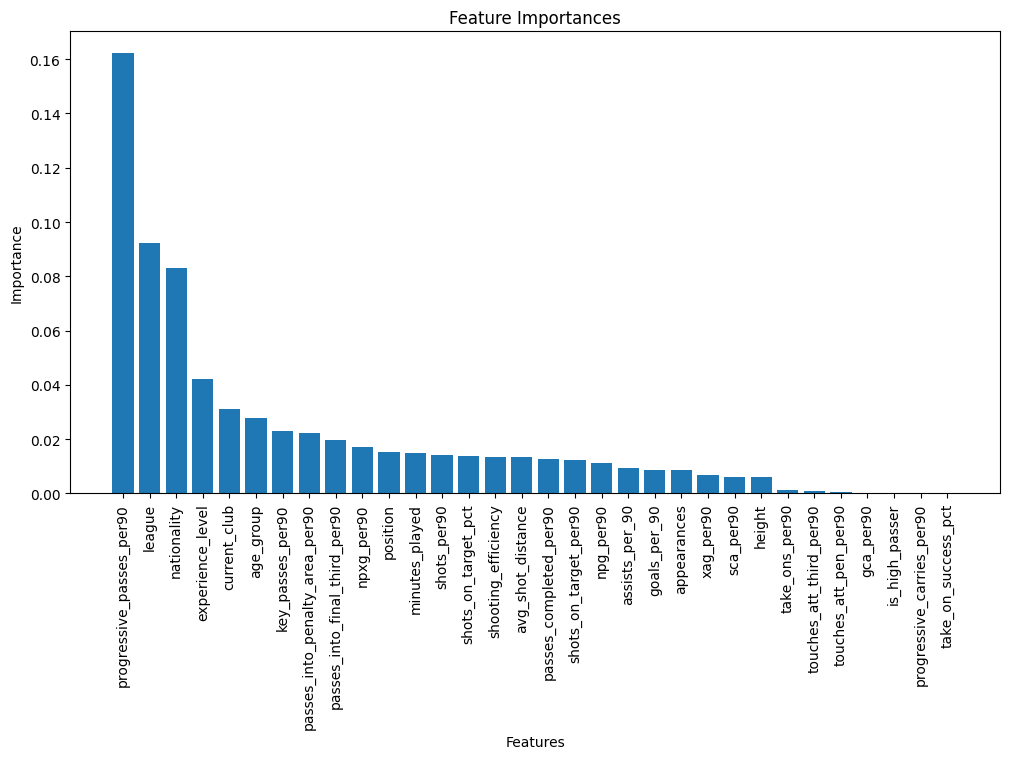

In [125]:
features, importances = zip(*sorted(
    zip(X_fw.columns, best_model.feature_importances_),
    key=lambda x: x[1],
    reverse=True
))

# Vẽ bar chart
plt.figure(figsize=(12,6))
plt.bar(features, importances)
plt.xticks(rotation=90)
plt.xlabel("Features")
plt.ylabel("Importance")
plt.title("Feature Importances")
plt.show()

# MF model

In [126]:
mf_cols = [
    'goals_per_90', 'npg_per90', 'npxg_per90',
    'xag_per90',

    'shots_per90', 'shots_on_target_per90',
    'shots_on_target_pct', 'avg_shot_distance',
    
    'assists_per_90',

    'sca_per90', 'gca_per90', 'key_passes_per90',

    'passes_completed_per90','passes_into_final_third_per90',
    'passes_into_penalty_area_per90', 'progressive_passes_per90',
    'is_high_passer',

    'progressive_carries_per90', 'take_ons_per90',
    'take_on_success_pct', 'touches_att_third_per90',
    
    'tackles_per90', 'interceptions_per90', 'blocks_per90',
    'ball_recoveries_per90'
]

mf_cols = info_columns + mf_cols + [TARGET]

In [127]:
df_mf = df[df['is_MF'] == 1]

In [128]:
df_mf_selected =  df_mf[mf_cols]

In [129]:
df_mf_selected.info()

<class 'pandas.core.frame.DataFrame'>
Index: 6706 entries, 5 to 16453
Data columns (total 35 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   height                          6706 non-null   float64
 1   position                        6706 non-null   object 
 2   nationality                     6619 non-null   object 
 3   current_club                    6706 non-null   object 
 4   league                          6706 non-null   object 
 5   appearances                     6706 non-null   int64  
 6   minutes_played                  6706 non-null   int64  
 7   age_group                       6706 non-null   object 
 8   experience_level                6421 non-null   object 
 9   goals_per_90                    6706 non-null   float64
 10  npg_per90                       6706 non-null   float64
 11  npxg_per90                      6706 non-null   float64
 12  xag_per90                       6706 n

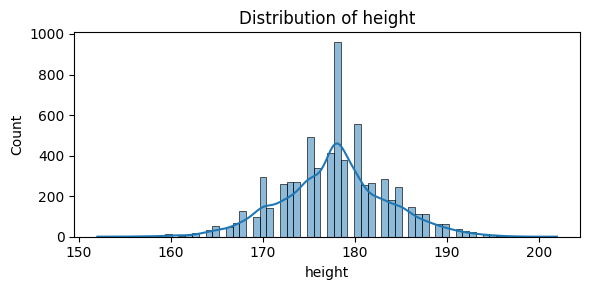

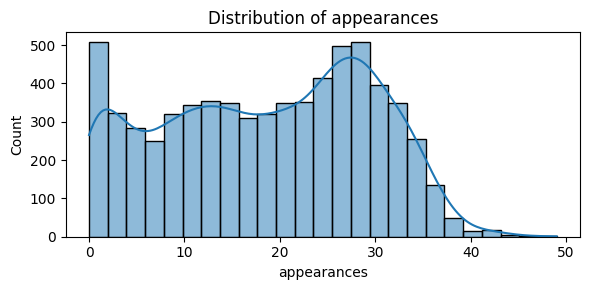

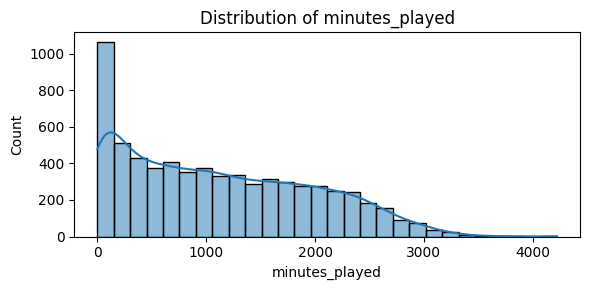

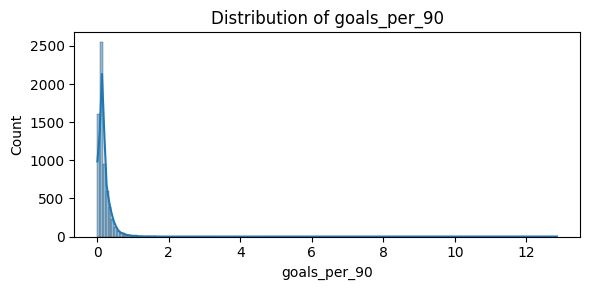

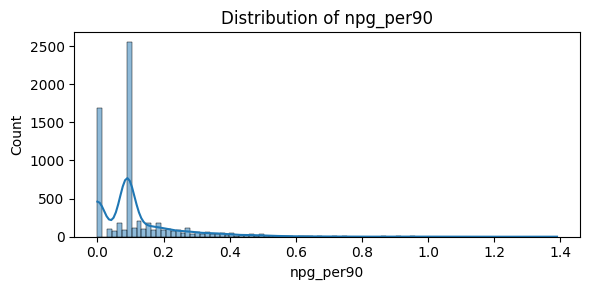

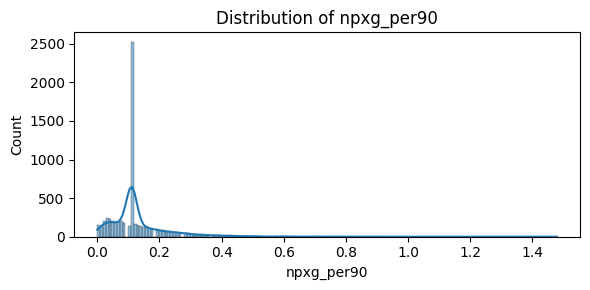

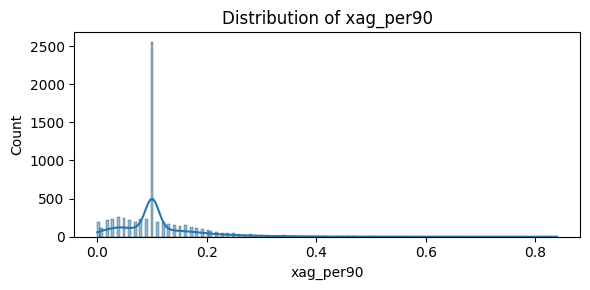

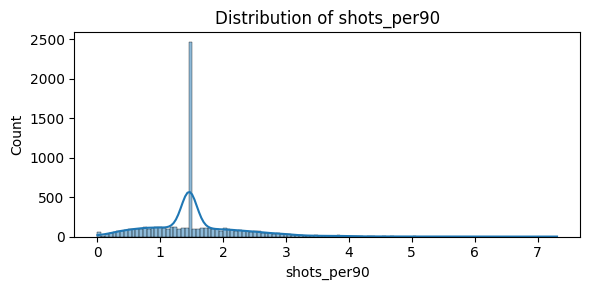

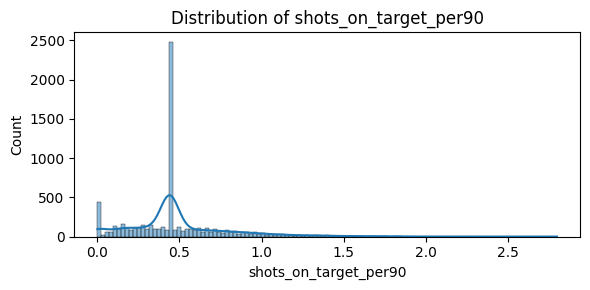

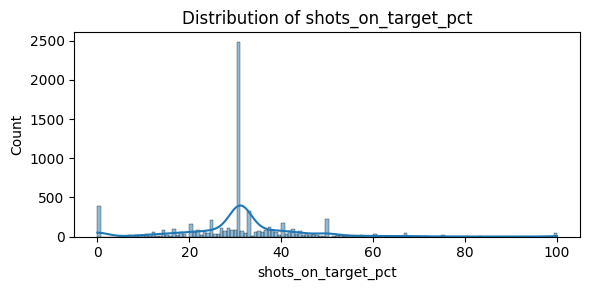

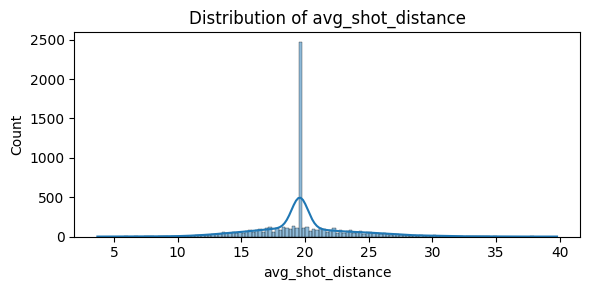

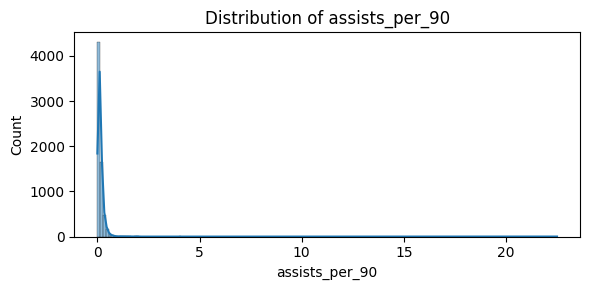

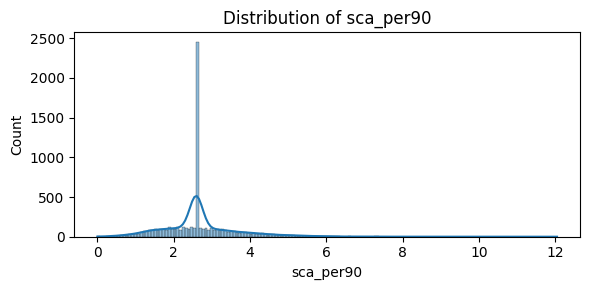

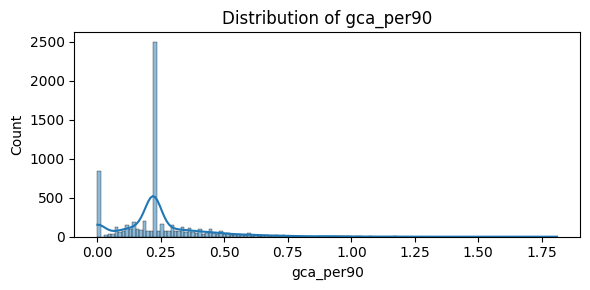

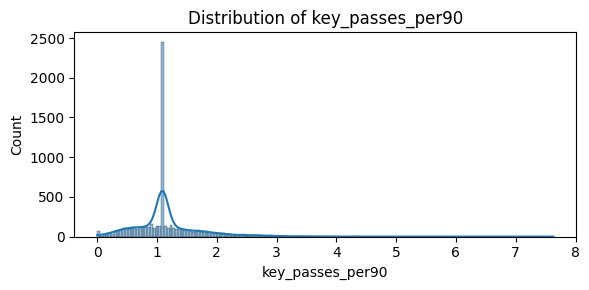

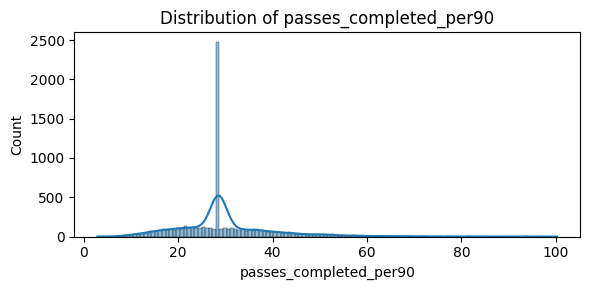

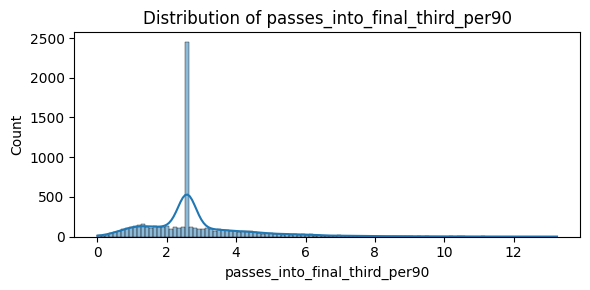

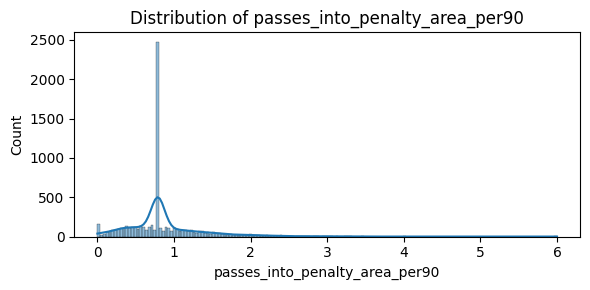

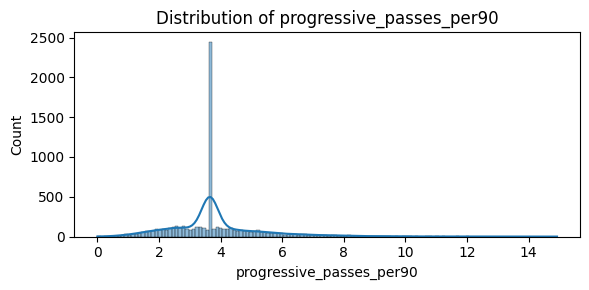

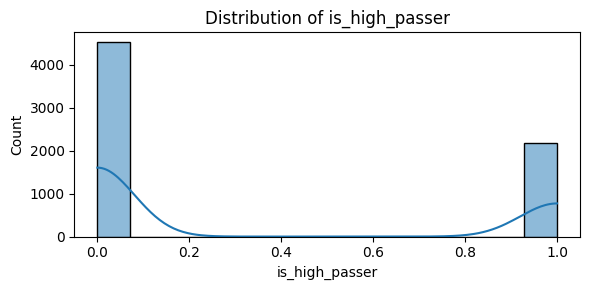

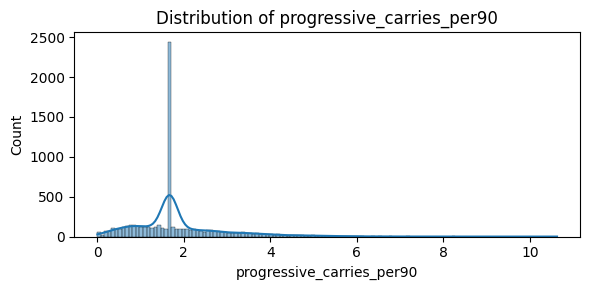

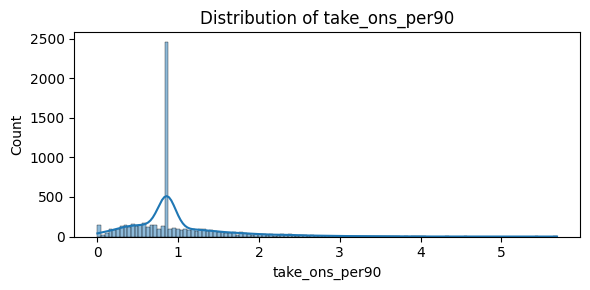

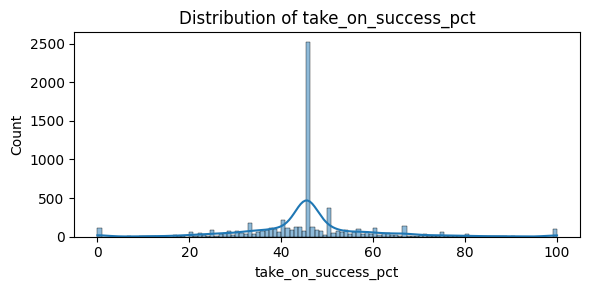

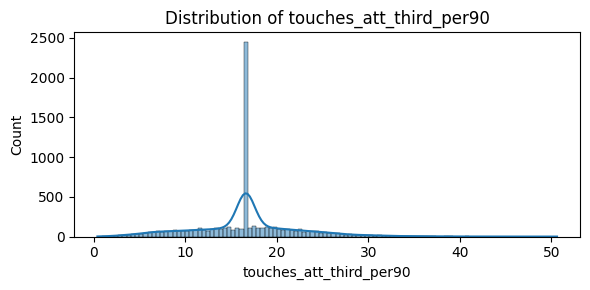

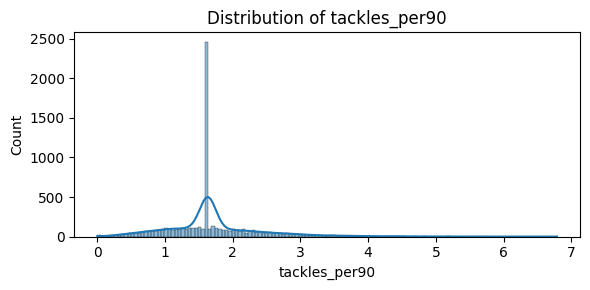

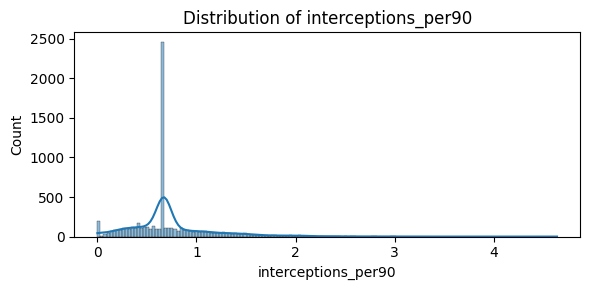

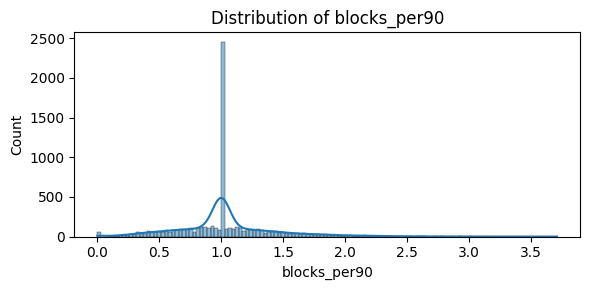

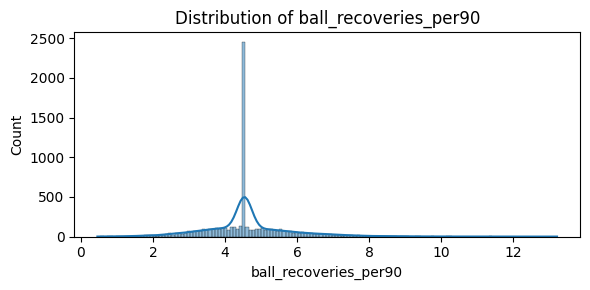

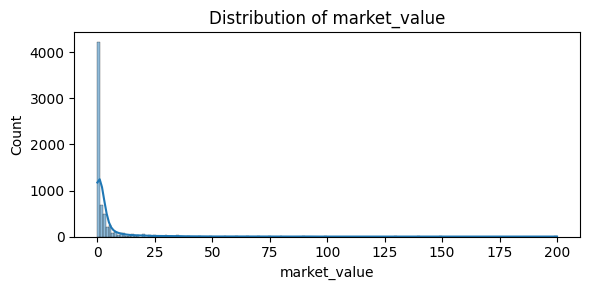

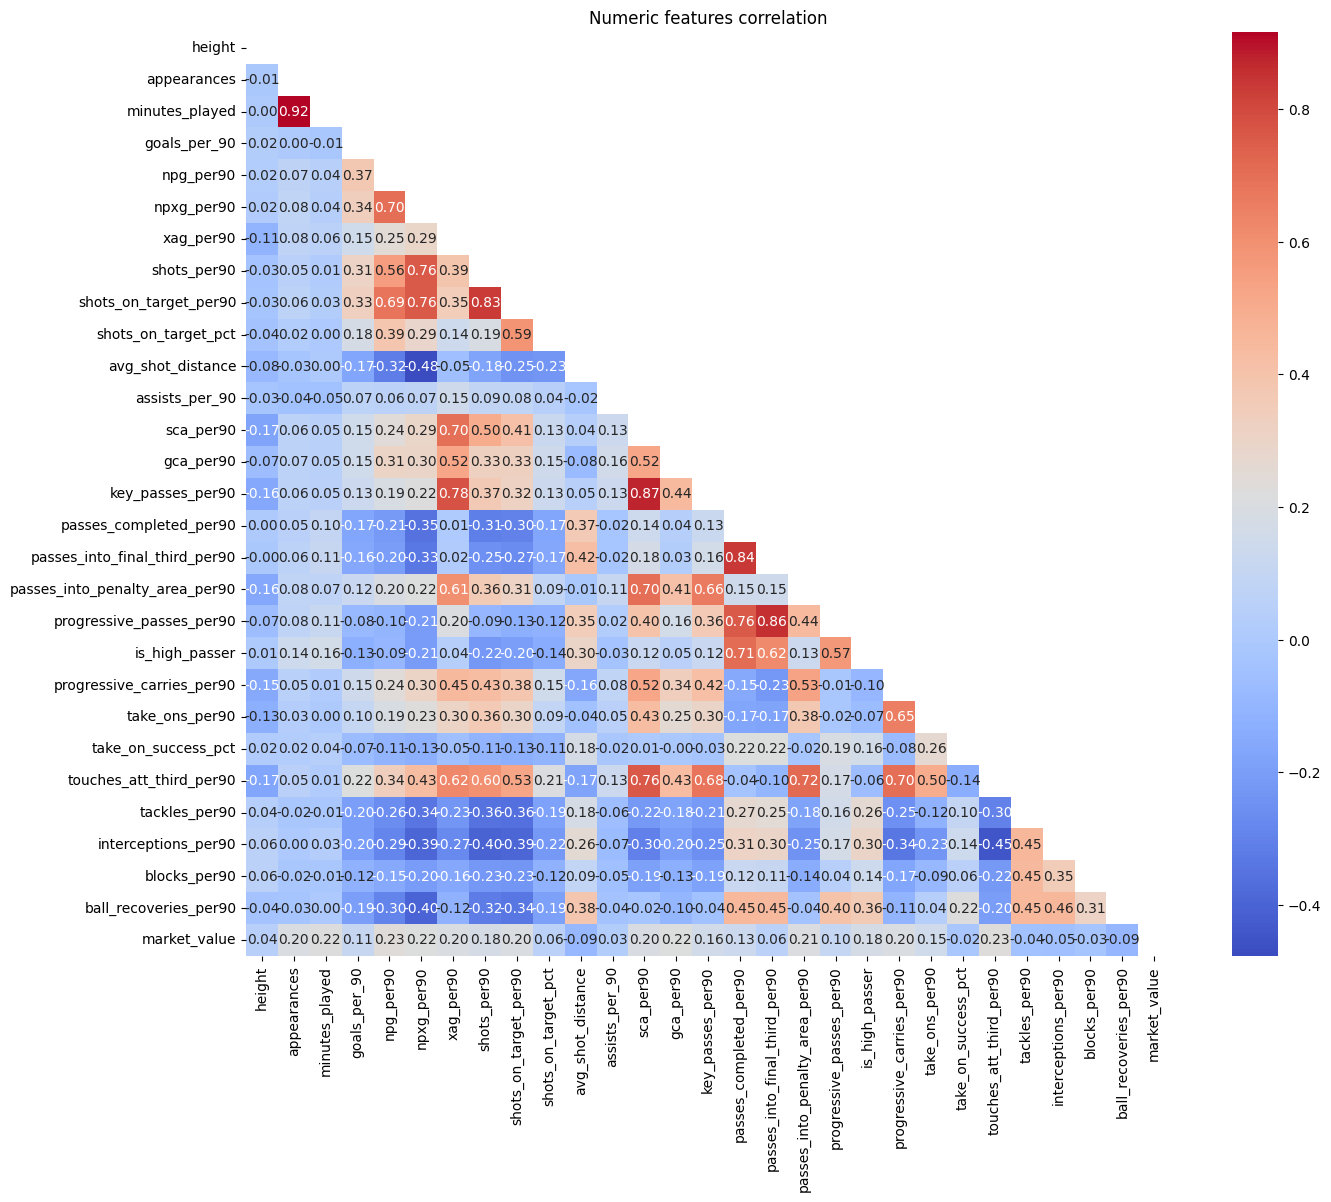

In [130]:
num_cols = df_mf_selected.select_dtypes(include=[np.number]).columns.tolist()


for c in num_cols:
    plt.figure(figsize=(6,3))
    sns.histplot(df_mf_selected[c].dropna(), kde=True)
    plt.title(f'Distribution of {c}')
    plt.tight_layout()
    plt.show()

corr = df_mf_selected[num_cols].corr()

# Tạo mask tam giác trên
mask = np.triu(np.ones_like(corr, dtype=bool))

plt.figure(figsize=(16, 12))
sns.heatmap(
    corr,
    mask=mask,
    annot=True,
    fmt='.2f',
    cmap='coolwarm',
    square=True
)
plt.title('Numeric features correlation')
plt.show()

In [131]:
X_mf = df_mf_selected.drop(columns=[TARGET])
y_mf = df_mf_selected[TARGET]

In [132]:
bins = pd.qcut(np.log1p(y_mf), q=10, labels=False, duplicates='drop')
X_mf_train, X_mf_test, y_mf_train, y_mf_test = train_test_split(X_mf, y_mf, test_size = 0.2, random_state=42, stratify=bins)

In [133]:
num_cols = X_mf_train.select_dtypes(include=[np.number]).columns.tolist()
cat_cols = X_mf_train.select_dtypes(exclude=[np.number]).columns.tolist()

<Axes: >

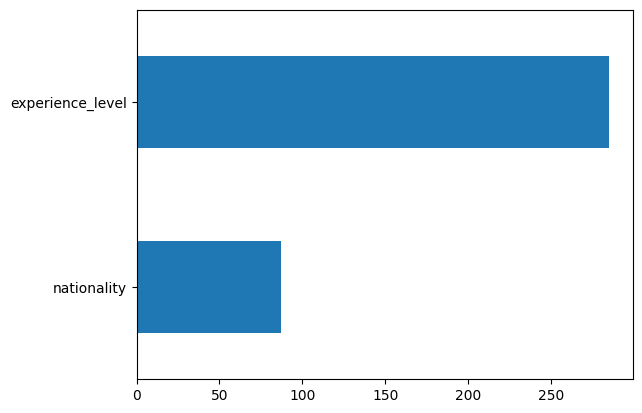

In [134]:
mf_missing = df_mf_selected.isna().sum()
mf_missing= mf_missing[mf_missing > 0].sort_values()

mf_missing.plot(kind='barh')

In [135]:
nationality_missing_fill = X_mf_train['nationality'].mode()[0]
X_mf_train['nationality'] = X_mf_train['nationality'].fillna(nationality_missing_fill)
X_mf_test['nationality'] = X_mf_test['nationality'].fillna(nationality_missing_fill)

In [136]:
X_mf_train['experience_level'] = X_mf_train['experience_level'].fillna(0)
X_mf_test['experience_level'] = X_mf_test['experience_level'].fillna(0)

In [137]:
X_mf_train = pd.get_dummies(X_mf_train, columns=cat_cols, drop_first=True)
X_mf_test = pd.get_dummies(X_mf_test, columns=cat_cols, drop_first=True)
X_mf_test = X_mf_test.reindex(columns=X_mf_train.columns, fill_value=0)

In [138]:
gb_model = GradientBoostingRegressor(random_state=42)

In [139]:
y_mf_train_log = np.log1p(y_mf_train)
y_mf_test_log = np.log1p(y_mf_test)

In [140]:
gb_model.fit(X_mf_train, y_mf_train_log)

GradientBoostingRegressor(random_state=42)

In [141]:
y_mf_pred_log = gb_model.predict(X_mf_test)
y_mf_pred = np.expm1(y_mf_pred_log)
mae = mean_absolute_error(y_mf_test, y_mf_pred)
rmse = root_mean_squared_error(y_mf_test, y_mf_pred)
r2 = r2_score(y_mf_test, y_mf_pred)

print(f'MAE: {mae:.4f}')
print(f'RMSE: {rmse:.4f}')
print(f'r2_score: {r2:.4f}')

MAE: 2.3067
RMSE: 6.7050
r2_score: 0.5036


In [142]:
param_dist = {
    'n_estimators': randint(200, 600),
    'learning_rate': uniform(0.03, 0.1),
    'max_depth': randint(2, 4),
    'min_samples_leaf': randint(10, 40),
    'subsample': uniform(0.7, 0.3),
    'max_features': ['sqrt', None],
    'loss': ['squared_error', 'huber']
}

In [143]:
mf_random_search = RandomizedSearchCV(
    GradientBoostingRegressor(
        random_state=42
    ),
    param_distributions=param_dist,
    n_iter=50,       
    cv=3,            
    scoring='neg_mean_absolute_error',
    n_jobs=-1,
    verbose=2,
    random_state=42
)


In [144]:
mf_random_search.fit(X_mf_train, y_mf_train_log)

Fitting 3 folds for each of 50 candidates, totalling 150 fits


RandomizedSearchCV(cv=3, estimator=GradientBoostingRegressor(random_state=42),
                   n_iter=50, n_jobs=-1,
                   param_distributions={'learning_rate': <scipy.stats._distn_infrastructure.rv_continuous_frozen object at 0x000002698AC70FC0>,
                                        'loss': ['squared_error', 'huber'],
                                        'max_depth': <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x0000026983489DD0>,
                                        'max_fe...
                                        'min_samples_leaf': <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x00000269837C50D0>,
                                        'n_estimators': <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x00000269FF9024E0>,
                                        'subsample': <scipy.stats._distn_infrastructure.rv_continuous_frozen object at 0x00000269FF1968D0>},
                   random_state=42, scoring='neg_mean_absolute_error',
                   verbose=2)

In [145]:
best_model = mf_random_search.best_estimator_

y_mf_test_pred_log = best_model.predict(X_mf_test)
y_mf_test_pred = np.expm1(y_mf_test_pred_log)

mae = mean_absolute_error(y_mf_test, y_mf_test_pred)
rmse = root_mean_squared_error(y_mf_test, y_mf_test_pred)
r2 = r2_score(y_mf_test, y_mf_test_pred)

print(f'MAE: {mae:.4f}')
print(f'RMSE: {rmse:.4f}')
print(f'r2_score: {r2:.4f}')

MAE: 2.1326
RMSE: 6.0673
r2_score: 0.5935


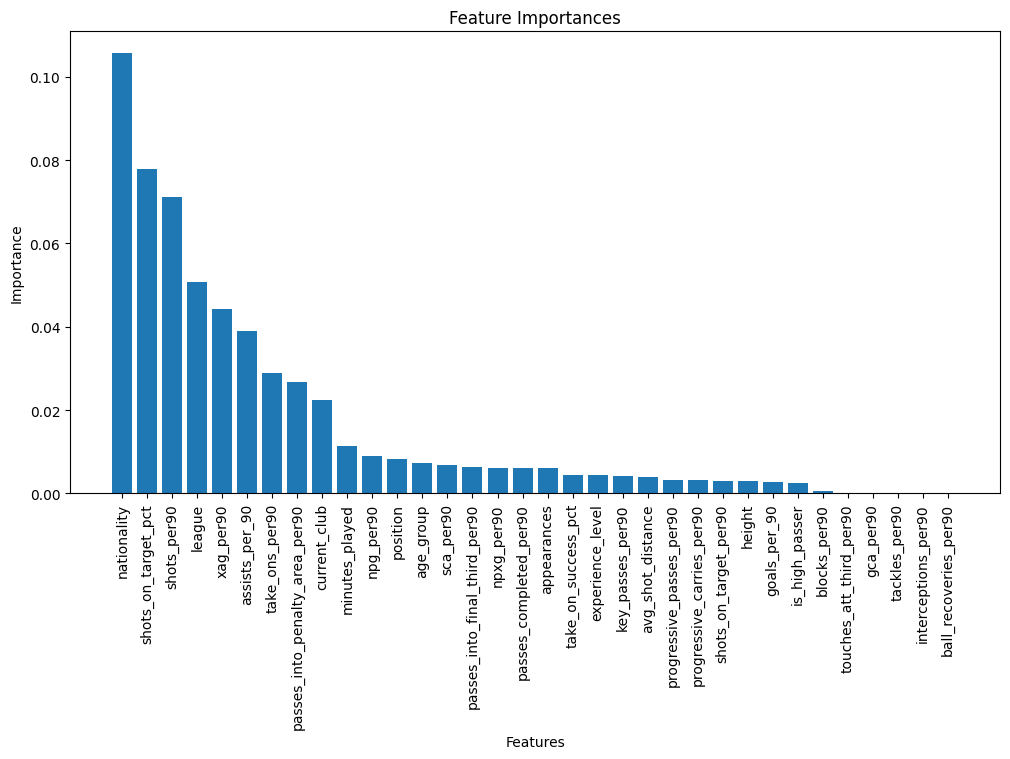

In [146]:
features, importances = zip(*sorted(
    zip(X_mf.columns, best_model.feature_importances_),
    key=lambda x: x[1],
    reverse=True
))

# Vẽ bar chart
plt.figure(figsize=(12,6))
plt.bar(features, importances)
plt.xticks(rotation=90)
plt.xlabel("Features")
plt.ylabel("Importance")
plt.title("Feature Importances")
plt.show()

# DF model

In [147]:
df_cols = [

    'shots_per90', 'shots_on_target_per90',
    'shots_on_target_pct', 'avg_shot_distance',

    'passes_completed_per90','passes_into_final_third_per90', 
    'progressive_passes_per90', 'is_high_passer',

    'progressive_carries_per90', 

    'tackles_per90', 'interceptions_per90', 'blocks_per90',
    'ball_recoveries_per90', 'aerials_won_per90', 'aerial_win_pct',

    'yellow_cards_per90', 'red_cards_per90', 'fouls_committed_per90'

]

df_cols = info_columns + df_cols + [TARGET]

In [148]:
df_df = df[df['is_DF'] == 1]

In [149]:
df_df_selected = df_df[df_cols]

In [150]:
df_df_selected.info()

<class 'pandas.core.frame.DataFrame'>
Index: 5897 entries, 2 to 16450
Data columns (total 28 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   height                         5897 non-null   float64
 1   position                       5897 non-null   object 
 2   nationality                    5830 non-null   object 
 3   current_club                   5897 non-null   object 
 4   league                         5897 non-null   object 
 5   appearances                    5897 non-null   int64  
 6   minutes_played                 5897 non-null   int64  
 7   age_group                      5897 non-null   object 
 8   experience_level               5559 non-null   object 
 9   shots_per90                    5897 non-null   float64
 10  shots_on_target_per90          5897 non-null   float64
 11  shots_on_target_pct            5897 non-null   float64
 12  avg_shot_distance              5897 non-null   float

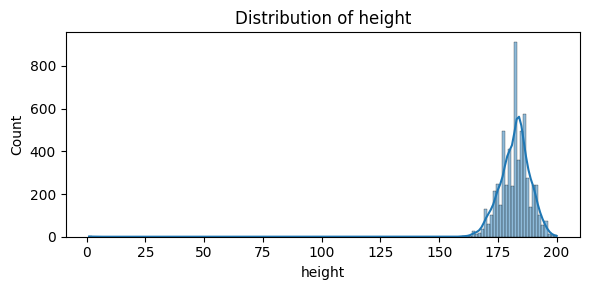

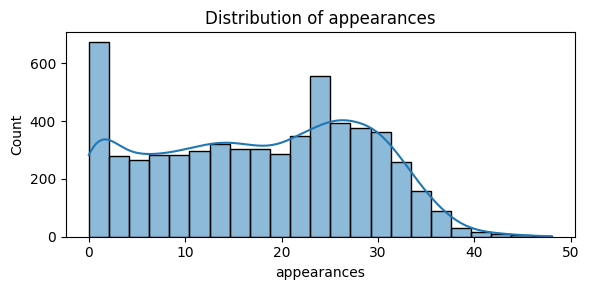

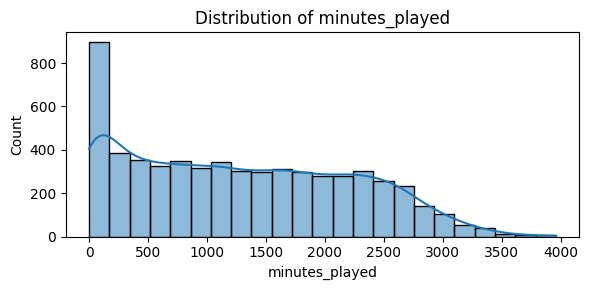

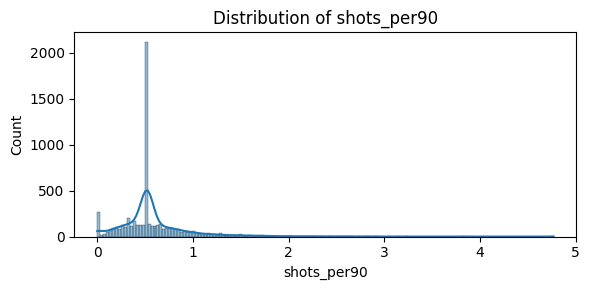

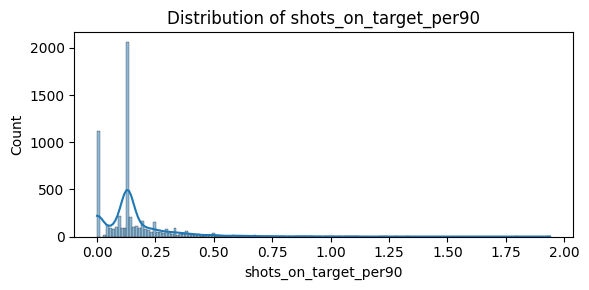

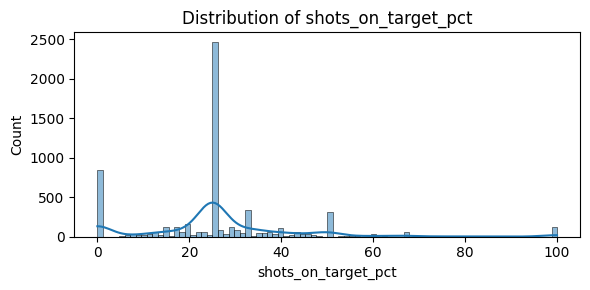

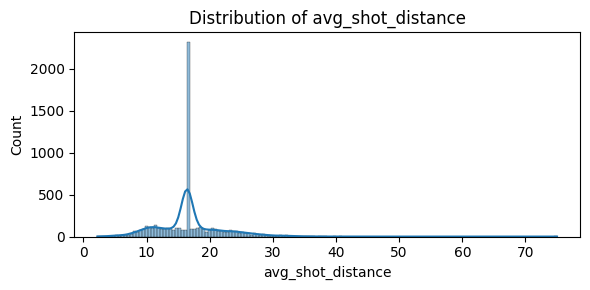

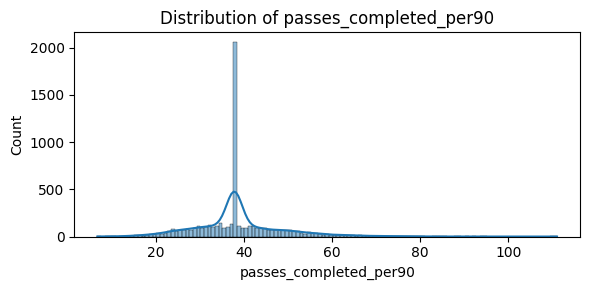

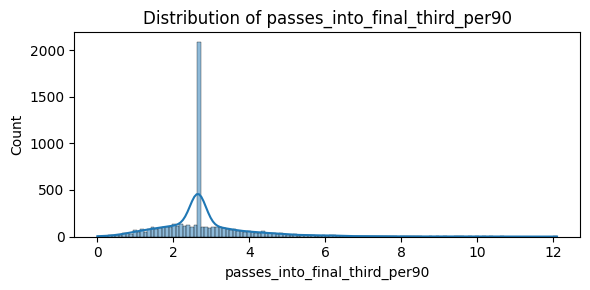

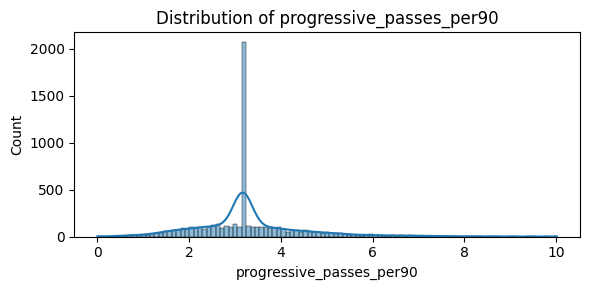

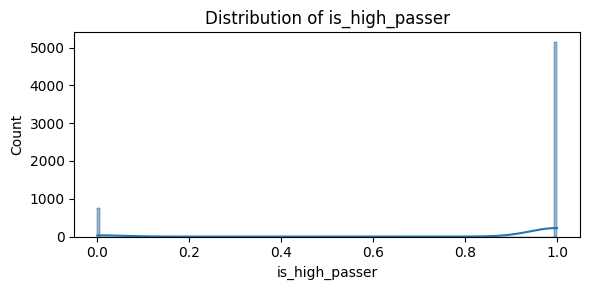

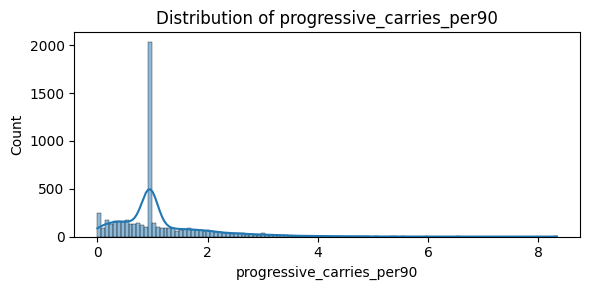

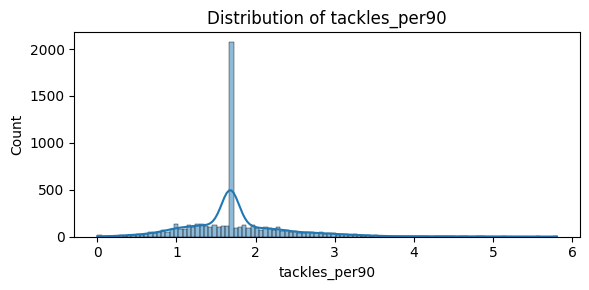

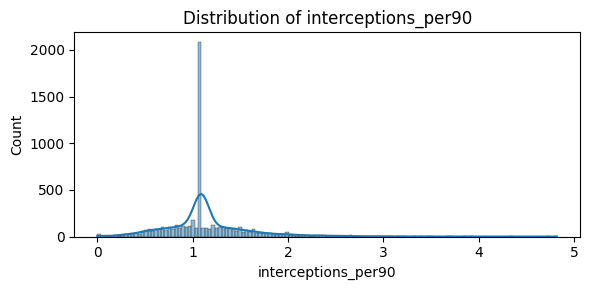

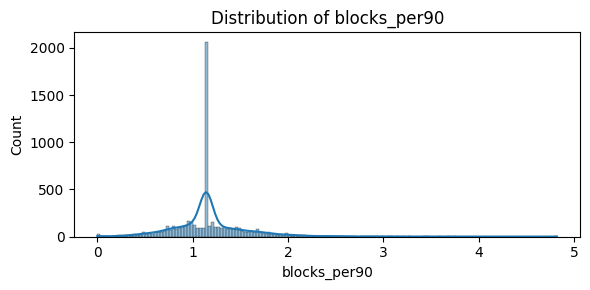

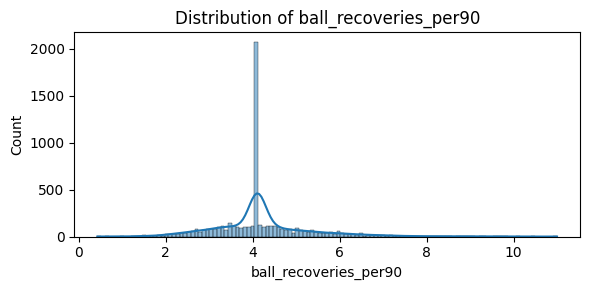

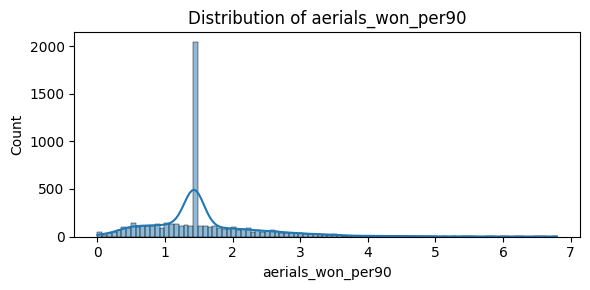

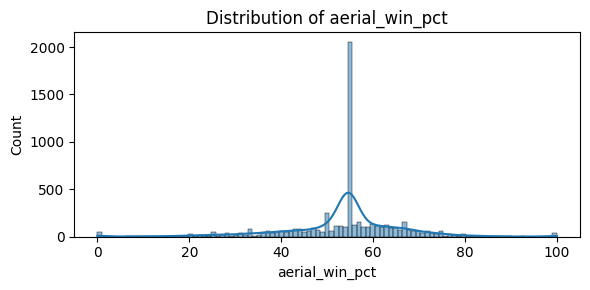

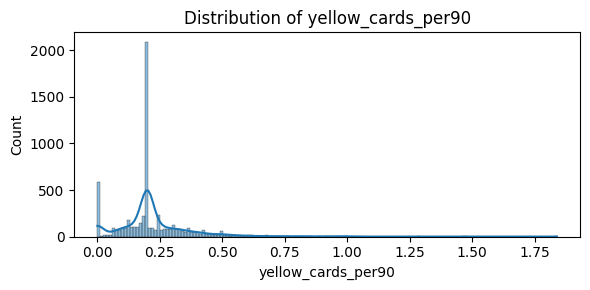

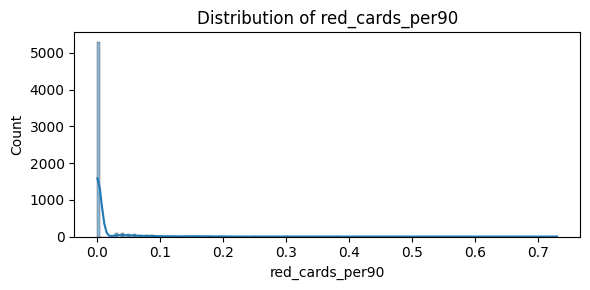

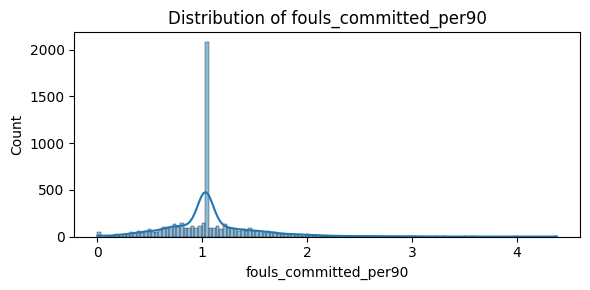

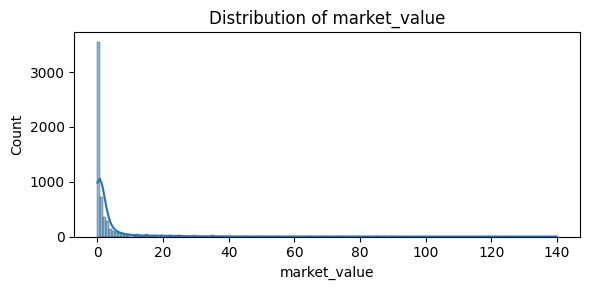

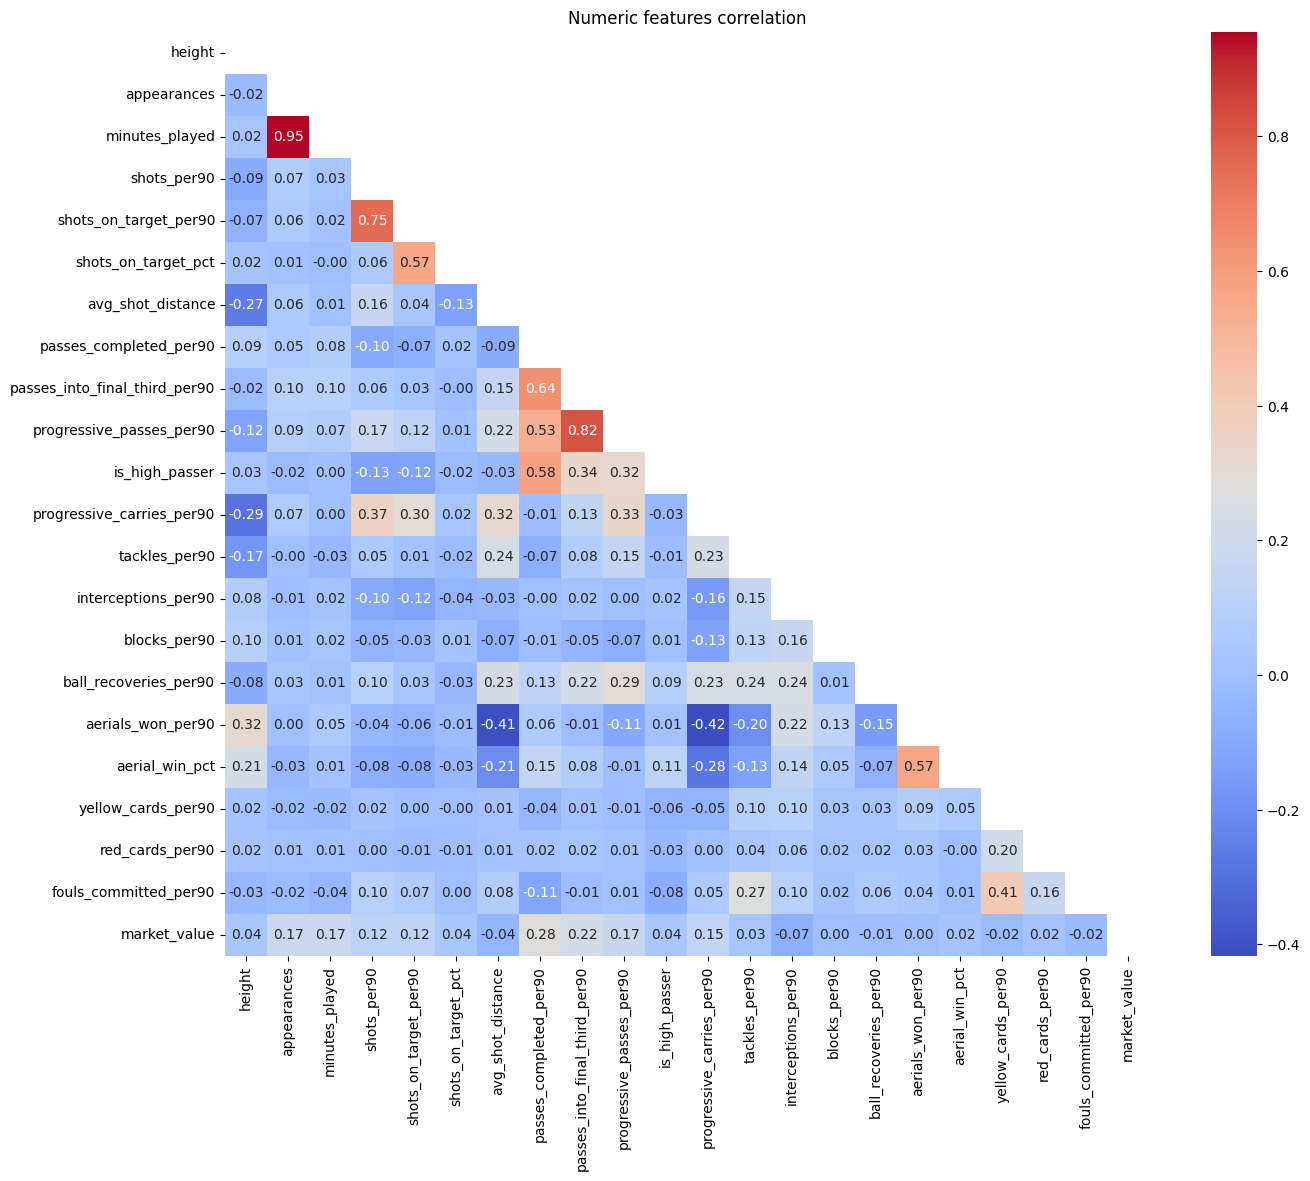

In [151]:
num_cols = df_df_selected.select_dtypes(include=[np.number]).columns.tolist()


for c in num_cols:
    plt.figure(figsize=(6,3))
    sns.histplot(df_df_selected[c].dropna(), kde=True)
    plt.title(f'Distribution of {c}')
    plt.tight_layout()
    plt.show()

corr = df_df_selected[num_cols].corr()

# Tạo mask tam giác trên
mask = np.triu(np.ones_like(corr, dtype=bool))

plt.figure(figsize=(16, 12))
sns.heatmap(
    corr,
    mask=mask,
    annot=True,
    fmt='.2f',
    cmap='coolwarm',
    square=True
)
plt.title('Numeric features correlation')
plt.show()

<Axes: >

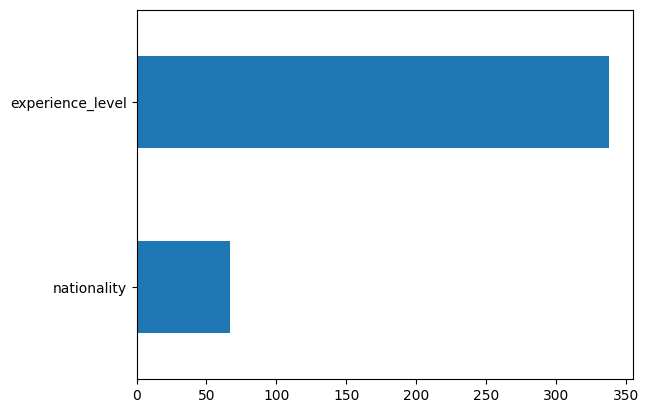

In [152]:
X_df = df_df_selected.drop(columns=[TARGET])
y_df = df_df_selected[TARGET]

bins = pd.qcut(np.log1p(y_df), q=10, labels=False, duplicates='drop')
X_df_train, X_df_test, y_df_train, y_df_test = train_test_split(X_df, y_df, test_size = 0.2, random_state=42, stratify=bins)

num_cols = X_df_train.select_dtypes(include=[np.number]).columns.tolist()
cat_cols = X_df_train.select_dtypes(exclude=[np.number]).columns.tolist()

df_missing = df_df_selected.isna().sum()
df_missing= df_missing[df_missing > 0].sort_values()

df_missing.plot(kind='barh')

In [153]:
nationality_missing_fill = X_df_train['nationality'].mode()[0]
X_df_train['nationality'] = X_df_train['nationality'].fillna(nationality_missing_fill)
X_df_test['nationality'] = X_df_test['nationality'].fillna(nationality_missing_fill)

In [154]:
X_df_train['experience_level'] = X_df_train['experience_level'].fillna(0)
X_df_test['experience_level'] = X_df_test['experience_level'].fillna(0)

In [155]:
X_df_train = pd.get_dummies(X_df_train, columns=cat_cols, drop_first=True)
X_df_test = pd.get_dummies(X_df_test, columns=cat_cols, drop_first=True)
X_df_test = X_df_test.reindex(columns=X_df_train.columns, fill_value=0)

In [156]:
gb_model = GradientBoostingRegressor(random_state=42)

y_df_train_log = np.log1p(y_df_train)
y_df_test_log = np.log1p(y_df_test)

gb_model.fit(X_df_train, y_df_train_log)

GradientBoostingRegressor(random_state=42)

In [157]:
y_df_pred_log = gb_model.predict(X_df_test)
y_df_pred = np.expm1(y_df_pred_log)
mae = mean_absolute_error(y_df_test, y_df_pred)
rmse = root_mean_squared_error(y_df_test, y_df_pred)
r2 = r2_score(y_df_test, y_df_pred)

print(f'MAE: {mae:.4f}')
print(f'RMSE: {rmse:.4f}')
print(f'r2_score: {r2:.4f}')

MAE: 2.0619
RMSE: 7.0943
r2_score: 0.3299


In [158]:
param_dist = {
    'n_estimators': randint(200, 600),
    'learning_rate': uniform(0.03, 0.1),
    'max_depth': randint(2, 4),
    'min_samples_leaf': randint(10, 40),
    'subsample': uniform(0.7, 0.3),
    'max_features': ['sqrt', None],
    'loss': ['squared_error', 'huber']
}


df_random_search = RandomizedSearchCV(
    GradientBoostingRegressor(
        random_state=42
    ),
    param_distributions=param_dist,
    n_iter=50,       
    cv=3,            
    scoring='neg_mean_absolute_error',
    n_jobs=-1,
    verbose=2,
    random_state=42
)


df_random_search.fit(X_df_train, y_df_train_log)

Fitting 3 folds for each of 50 candidates, totalling 150 fits


RandomizedSearchCV(cv=3, estimator=GradientBoostingRegressor(random_state=42),
                   n_iter=50, n_jobs=-1,
                   param_distributions={'learning_rate': <scipy.stats._distn_infrastructure.rv_continuous_frozen object at 0x00000269857CE2D0>,
                                        'loss': ['squared_error', 'huber'],
                                        'max_depth': <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x0000026985825C50>,
                                        'max_fe...
                                        'min_samples_leaf': <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x00000269858263C0>,
                                        'n_estimators': <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x0000026985825A90>,
                                        'subsample': <scipy.stats._distn_infrastructure.rv_continuous_frozen object at 0x000002698A81CF70>},
                   random_state=42, scoring='neg_mean_absolute_error',
                   verbose=2)

In [159]:
best_model = df_random_search.best_estimator_

y_df_test_pred_log = best_model.predict(X_df_test)
y_df_test_pred = np.expm1(y_df_test_pred_log)

mae = mean_absolute_error(y_df_test, y_df_test_pred)
rmse = root_mean_squared_error(y_df_test, y_df_test_pred)
r2 = r2_score(y_df_test, y_df_test_pred)

print(f'MAE: {mae:.4f}')
print(f'RMSE: {rmse:.4f}')
print(f'r2_score: {r2:.4f}')

MAE: 2.0537
RMSE: 7.1606
r2_score: 0.3174


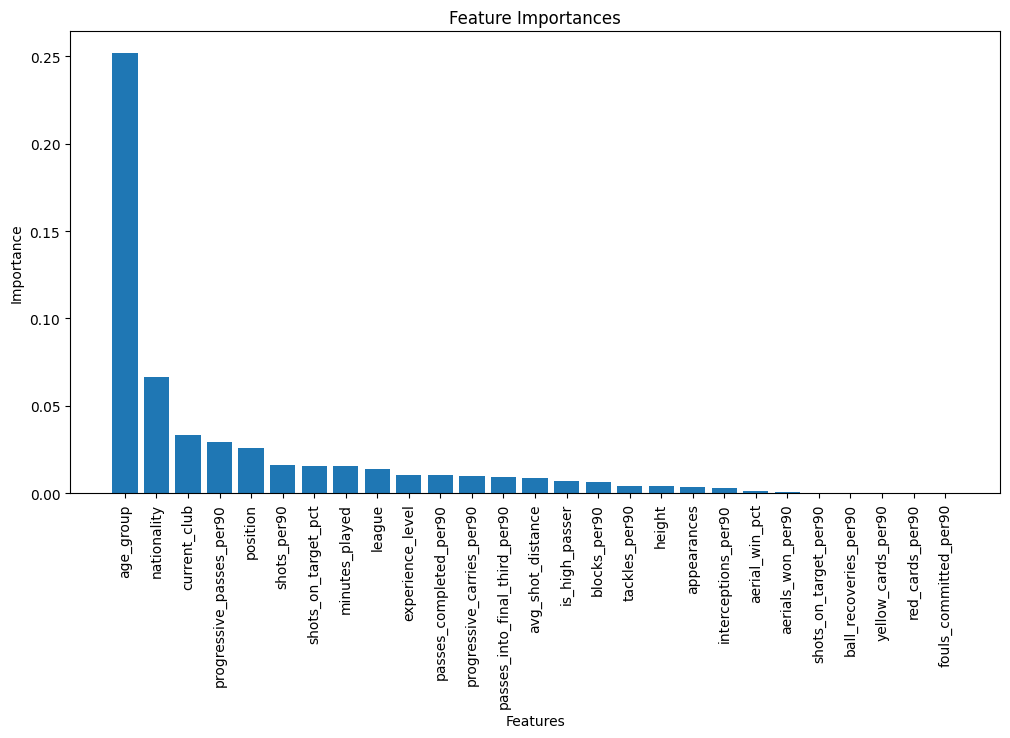

In [160]:
features, importances = zip(*sorted(
    zip(X_df.columns, best_model.feature_importances_),
    key=lambda x: x[1],
    reverse=True
))

# Vẽ bar chart
plt.figure(figsize=(12,6))
plt.bar(features, importances)
plt.xticks(rotation=90)
plt.xlabel("Features")
plt.ylabel("Importance")
plt.title("Feature Importances")
plt.show()

# GK model

In [161]:
gk_cols = [

    'goals_against_per90',
    'shots_on_target_against_per90',
    'saves_per90',
    'save_percentage',
    'clean_sheet_pct',
    'psxg_per_shot',
    'psxg_ga_per90',
    'penalty_save_pct',

    'launch_pct',
    'avg_pass_length',

    'def_actions_outside_pen_per90',
    'avg_distance_def_actions',

    'crosses_stopped_pct',

]

gk_cols = info_columns + gk_cols + [TARGET]

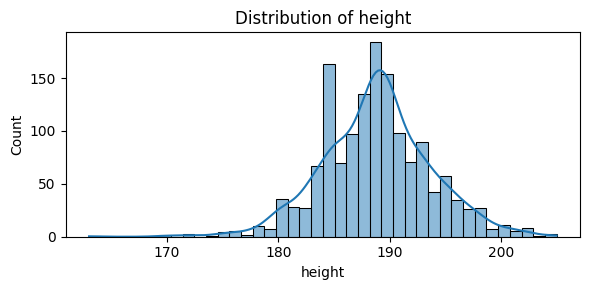

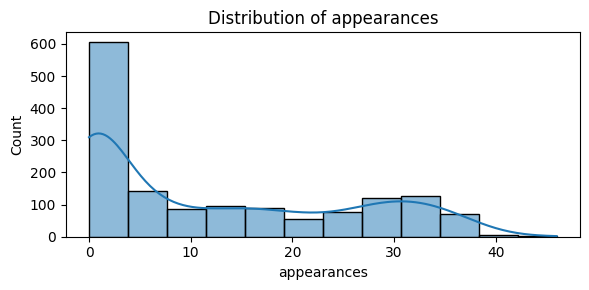

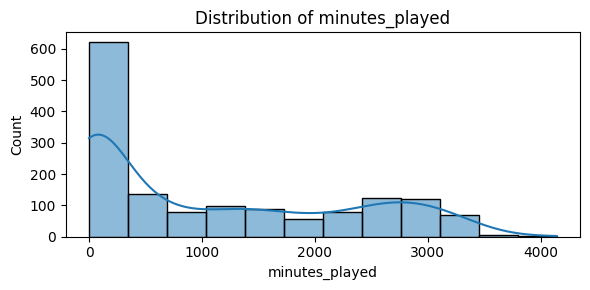

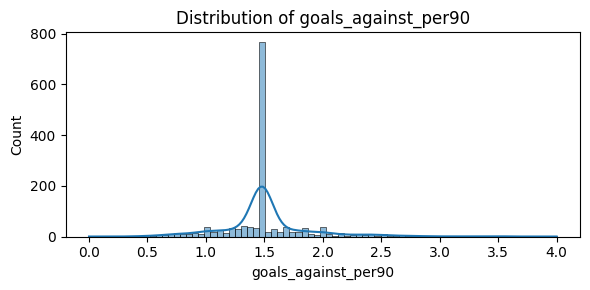

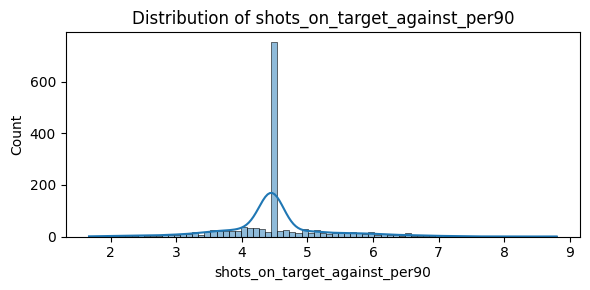

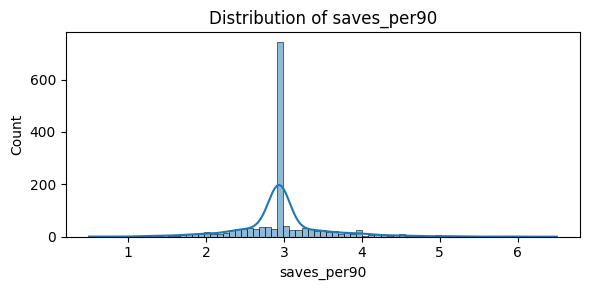

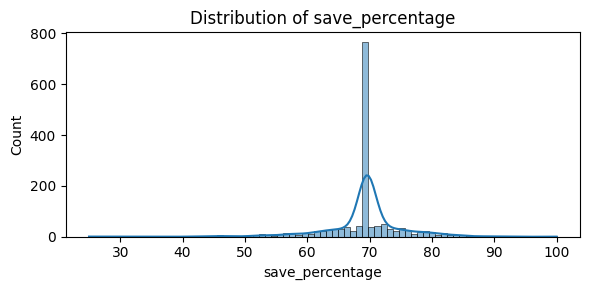

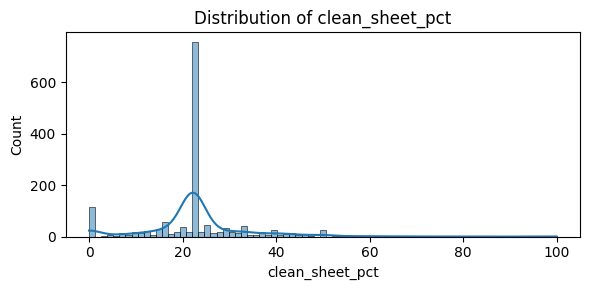

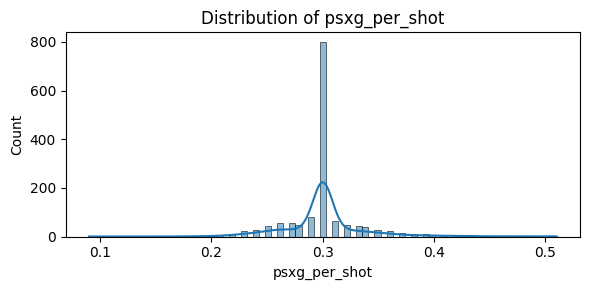

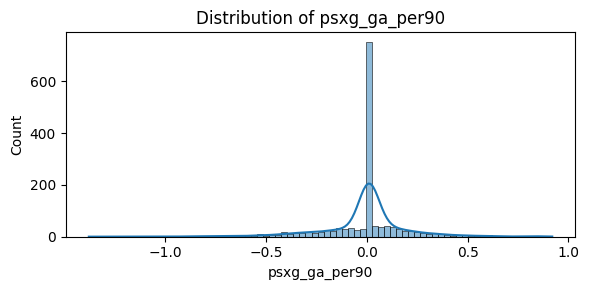

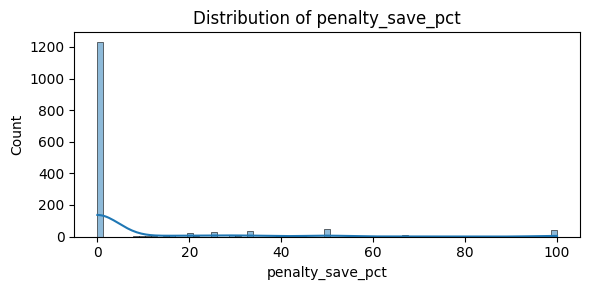

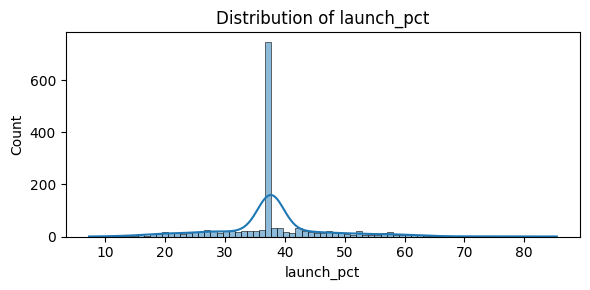

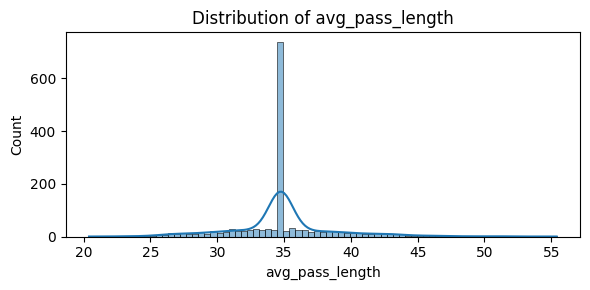

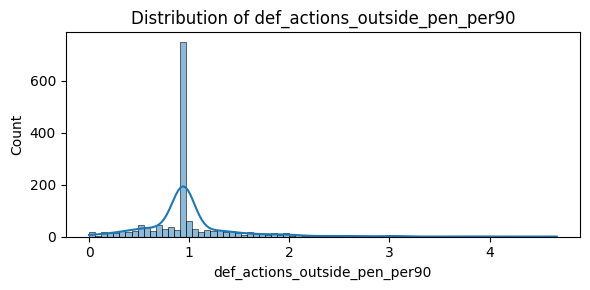

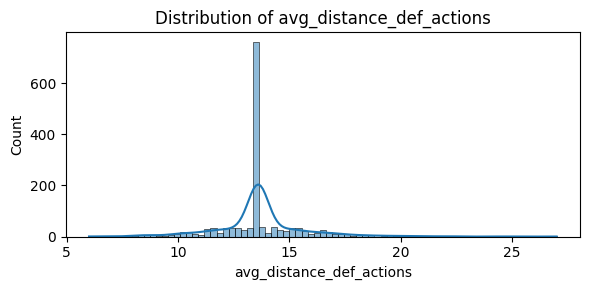

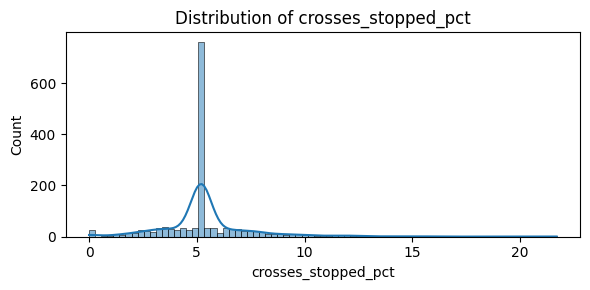

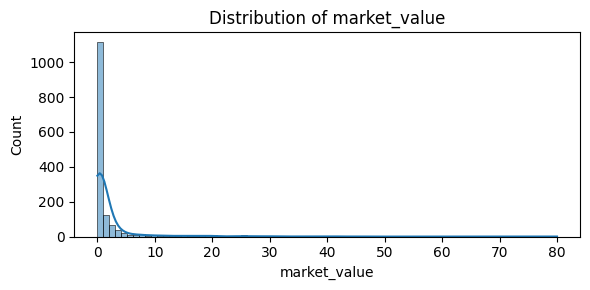

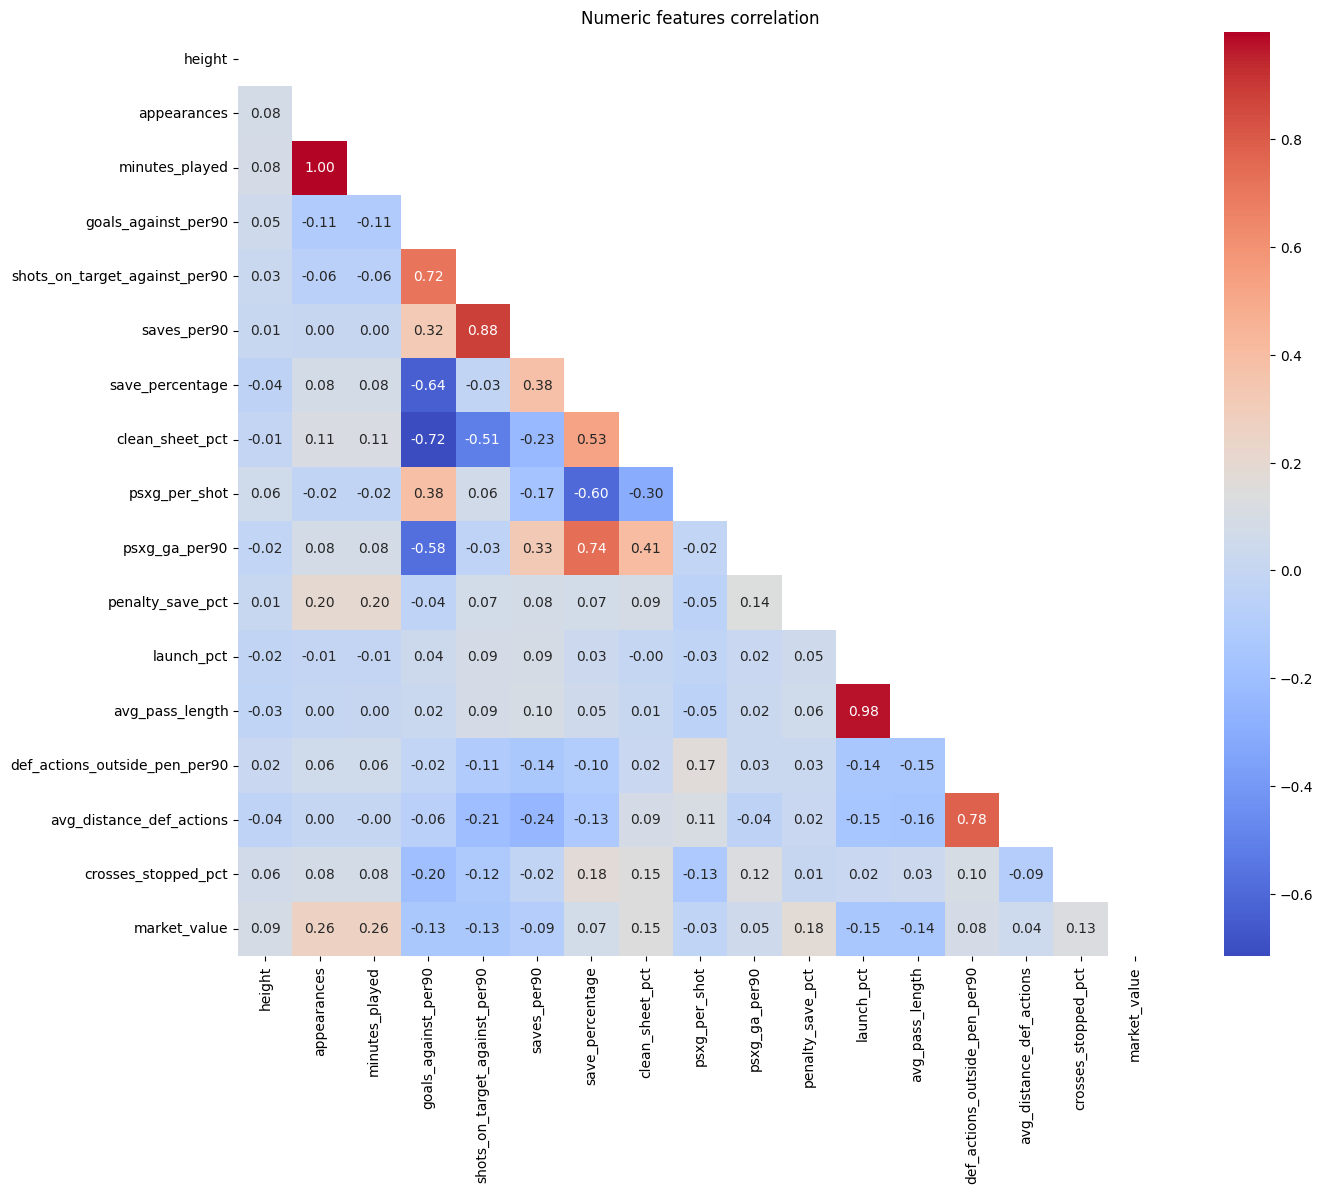

In [162]:
df_gk = df[df['is_GK'] == 1]
df_gk_selected = df_gk[gk_cols]

num_cols = df_gk_selected.select_dtypes(include=[np.number]).columns.tolist()

for c in num_cols:
    plt.figure(figsize=(6,3))
    sns.histplot(df_gk_selected[c].dropna(), kde=True)
    plt.title(f'Distribution of {c}')
    plt.tight_layout()
    plt.show()

corr = df_gk_selected[num_cols].corr()

# Tạo mask tam giác trên
mask = np.triu(np.ones_like(corr, dtype=bool))

plt.figure(figsize=(16, 12))
sns.heatmap(
    corr,
    mask=mask,
    annot=True,
    fmt='.2f',
    cmap='coolwarm',
    square=True
)
plt.title('Numeric features correlation')
plt.show()

<Axes: >

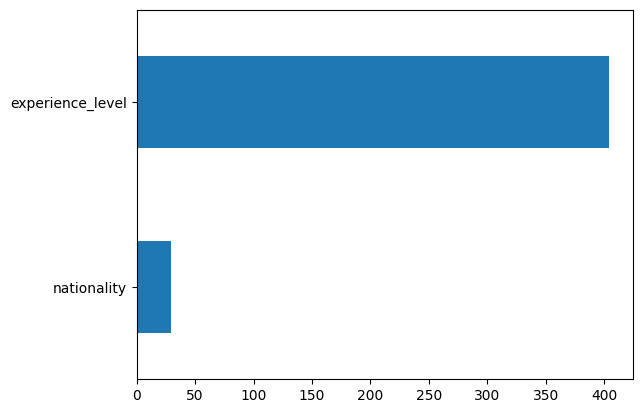

In [163]:
X_gk = df_gk_selected.drop(columns=[TARGET])
y_gk = df_gk_selected[TARGET]

bins = pd.qcut(np.log1p(y_gk), q=10, labels=False, duplicates='drop')
X_gk_train, X_gk_test, y_gk_train, y_gk_test = train_test_split(X_gk, y_gk, test_size = 0.2, random_state=42, stratify=bins)

num_cols = X_gk_train.select_dtypes(include=[np.number]).columns.tolist()
cat_cols = X_gk_train.select_dtypes(exclude=[np.number]).columns.tolist()

gk_missing = df_gk_selected.isna().sum()
gk_missing= gk_missing[gk_missing > 0].sort_values()

gk_missing.plot(kind='barh')

In [164]:
nationality_missing_fill = X_gk_train['nationality'].mode()[0]
X_gk_train['nationality'] = X_gk_train['nationality'].fillna(nationality_missing_fill)
X_gk_test['nationality'] = X_gk_test['nationality'].fillna(nationality_missing_fill)

X_gk_train['experience_level'] = X_gk_train['experience_level'].fillna(0)
X_gk_test['experience_level'] = X_gk_test['experience_level'].fillna(0)

In [165]:
X_gk_train = pd.get_dummies(X_gk_train, columns=cat_cols, drop_first=True)
X_gk_test = pd.get_dummies(X_gk_test, columns=cat_cols, drop_first=True)
X_gk_test = X_gk_test.reindex(columns=X_gk_train.columns, fill_value=0)

gb_model = GradientBoostingRegressor(random_state=42)

y_gk_train_log = np.log1p(y_gk_train)
y_gk_test_log = np.log1p(y_gk_test)

gb_model.fit(X_gk_train, y_gk_train_log)

y_gk_pred_log = gb_model.predict(X_gk_test)
y_gk_pred = np.expm1(y_gk_pred_log)
mae = mean_absolute_error(y_gk_test, y_gk_pred)
rmse = root_mean_squared_error(y_gk_test, y_gk_pred)
r2 = r2_score(y_gk_test, y_gk_pred)

print(f'MAE: {mae:.4f}')
print(f'RMSE: {rmse:.4f}')
print(f'r2_score: {r2:.4f}')

MAE: 1.2711
RMSE: 3.5112
r2_score: 0.2683


In [166]:
param_dist = {
    'n_estimators': randint(200, 600),
    'learning_rate': uniform(0.03, 0.1),
    'max_depth': randint(2, 4),
    'min_samples_leaf': randint(10, 40),
    'subsample': uniform(0.7, 0.3),
    'max_features': ['sqrt', None],
    'loss': ['squared_error', 'huber']
}

gk_random_search = RandomizedSearchCV(
    GradientBoostingRegressor(
        random_state=42
    ),
    param_distributions=param_dist,
    n_iter=50,       
    cv=3,            
    scoring='neg_mean_absolute_error',
    n_jobs=-1,
    verbose=2,
    random_state=42
)


gk_random_search.fit(X_gk_train, y_gk_train_log)

Fitting 3 folds for each of 50 candidates, totalling 150 fits


RandomizedSearchCV(cv=3, estimator=GradientBoostingRegressor(random_state=42),
                   n_iter=50, n_jobs=-1,
                   param_distributions={'learning_rate': <scipy.stats._distn_infrastructure.rv_continuous_frozen object at 0x000002698A81F8B0>,
                                        'loss': ['squared_error', 'huber'],
                                        'max_depth': <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x000002698A9D5F60>,
                                        'max_fe...
                                        'min_samples_leaf': <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x000002698A9D69E0>,
                                        'n_estimators': <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x000002698A9D5160>,
                                        'subsample': <scipy.stats._distn_infrastructure.rv_continuous_frozen object at 0x00000269FF97E8F0>},
                   random_state=42, scoring='neg_mean_absolute_error',
                   verbose=2)

In [168]:
best_model = gk_random_search.best_estimator_

y_gk_test_pred_log = best_model.predict(X_gk_test)
y_gk_test_pred = np.expm1(y_gk_test_pred_log)

mae = mean_absolute_error(y_gk_test, y_gk_test_pred)
rmse = root_mean_squared_error(y_gk_test, y_gk_test_pred)
r2 = r2_score(y_gk_test, y_gk_test_pred)

print(f'MAE: {mae:.4f}')
print(f'RMSE: {rmse:.4f}')
print(f'r2_score: {r2:.4f}')

MAE: 1.1913
RMSE: 3.3497
r2_score: 0.3340


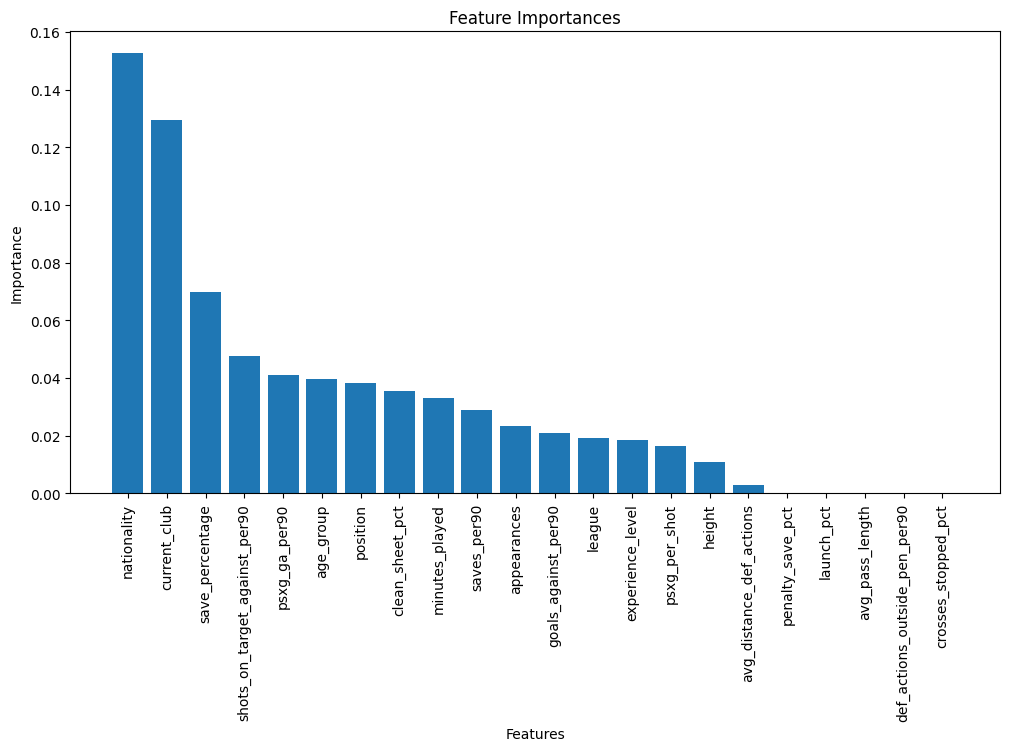

In [169]:
features, importances = zip(*sorted(
    zip(X_gk.columns, best_model.feature_importances_),
    key=lambda x: x[1],
    reverse=True
))

# Vẽ bar chart
plt.figure(figsize=(12,6))
plt.bar(features, importances)
plt.xticks(rotation=90)
plt.xlabel("Features")
plt.ylabel("Importance")
plt.title("Feature Importances")
plt.show()